In [2]:
# Importing Required Packages

# Importing 'pandas' to handle datasets
import pandas as pd
# Importing 'numpy' to handle arrays
import numpy as np

# Importing 're' package - Python Regular Expressions
import re

from datetime import datetime, timedelta
import requests 
import json 
from collections import OrderedDict
import json
import time

# Importing Matplotlib to visualize data
import matplotlib.pyplot as plt


# Remove Warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

### Step 1 - Preparing Data Sets 

Appending the following columns to the 'All_Routes_Complete.csv' file obtained from the Malta public transport (MPT) website

    1. 'Stop Island' - Defines the island (Malta/Gozo) the corresponding Route Number operates in. 
    2. 'Time_Count' - Number of buses operating on a particular Route Number and Route Direction from the start till the end of the bus service.
    3. 'Stops - City Name - Stop Island' - Key column used to compare data in 'All_Routes_Complete.csv' to data in Bus_Stop_Info ('Bus_Stop_Lon_Lat_Data_Final_Manual_Update.xlsx')
    4. 'Longitude_Final' - Longitude value of corresponding Bus Stop entry ('Stops') obtained from Bus_Stop_Info
    5. 'Latitude_Final' - Latitude value of corresponding Bus Stop entry ('Stops') obtained from Bus_Stop_Info
    6. 'Bus_Stop_ID' - Unique identifier for all Bus Stops ('Stops')
    7. 'Next_Bus_Stop_ID' - Since All_Routes ('All_Routes_Complete.csv') was extracted in sequential order from MPT website, the next row in All_Routes corresponds to the upcoming Bus Stop (Given 'Route Number', 'Route Direction' and 'Date' columns remain the same). Hence, 'Next_Bus_Stop_ID' is the unique identifier of the upcoming Bus Stop ('Stops')
    8. 'Bus_Stop_Next_Bus_Stop'- Unique identifier used to define connection between 'Bus_Stop_ID and 'Next_Bus_Stop_ID'

In [3]:
# Step 1.1 - Load Datasets
# Loading 'All_Routes_Complete.csv' (All_Routes) and 'Bus_Stop_Lon_Lat_Data_Final_Manual_Update.xlsx' (Bus_Stop_Info) Datasets
# Recall 'All_Routes_Complete.csv' is the file which was obtained from MPT website consisting of all Bus Schedules in sequential order
# Recall 'Bus_Stop_Lon_Lat_Data_Final_Manual_Update.xlsx' consits of the Longitude and Latitude data of all Bus Stops defined in 'All_Routes_Complete.csv' 

All_Routes = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Scraping Route Names from MPT Website//Results//All_Routes_Complete.csv", low_memory = False)
Bus_Stop_Info = pd.read_excel("C://Users//Owner//ICT5012 - Disseration//Obtaining Longitude and Latitude for all Bus Stops//Results (Checks Done + Manual Adjustment)//Bus_Stop_Lon_Lat_Data_Final_Manual_Update.xlsx")


In [4]:
# Step 1.2 - Create 'Stop Island' column
# To differentiate between stops in Malta and Gozo, stops with correspoding 'Route Number' belonging to the 'Gozitan_Route_Number'
# list will be labelled as 'GOZO STOP' whilst all other stops will be labelled as 'MALTA STOP' using a column entitled 'Stop Island' 

Gozitan_Route_Number = ['301', '302', '303',
                        '305', '306', '307',
                        '308', '309', '310',
                        '311', '312', '313',
                        '322', '323', '330',
                        'N301']

All_Routes['Stop Island'] = np.where(All_Routes['Route Number'].isin(Gozitan_Route_Number), 'GOZO STOP', 'MALTA STOP')

In [5]:
# Step 1.3 - Create 'Time_Count' column
# The 'Time_Count' column will be added to count the number of buses operating throughout one day for a particular route.
# 'Time_Count' will be used as another method to identify between different routes having the same 'Route Number', 'Route Direction' and 'Date' column

# Select all columns in 'All_Routes' that start with 'Stop Time'
Stop_Time_Columns = [col for col in All_Routes.columns if col.startswith('Stop Time')]
# Row-wise count all'Stop Time' columns which are filled in and populate the 'Time_Count' column with sum 
All_Routes['Time_Count'] = All_Routes[Stop_Time_Columns].notna().sum(axis=1)


In [6]:
# Step 1.4 - Merge 'Longitude_Final' and 'Latitude_Final' columns from 'Bus_Stop_Info' dataframe to 'All_Routes' dataframe

# Create column entitled 'Stops - City Name - Stop Island' (Concatenation of 'Stops', 'City Name' and 'Stop Island' columns) 
# in both 'All_Routes' and 'Bus_Stop_Info'
All_Routes['Stops - City Name - Stop Island'] = All_Routes['Stops'] + ' - ' + All_Routes['City Name'] + ' - ' + All_Routes['Stop Island']
Bus_Stop_Info['Stops - City Name - Stop Island'] = Bus_Stop_Info['Stops'] + ' - ' + Bus_Stop_Info['City Name'] + ' - ' + Bus_Stop_Info['Stop_Island']
# Merge 'Bus_Stop_Info' Dataframe to 'All_Routes' such that 'All_Routes' dataframe will have 'Longitude_Final' and 'Latitude_Final' values for all corresponding entries
All_Routes = pd.merge(All_Routes, Bus_Stop_Info[['Stops - City Name - Stop Island', 'Longitude_Final', 'Latitude_Final']], on = 'Stops - City Name - Stop Island', how = 'left', sort = False)

In [7]:
# Step 1.5 - Create a unique identifier for all Bus Stops ('Stops') entitled 'Bus_Stop_ID'

# Obtain Dataframe entitled 'Distinct_Coordinates' consisting only of entries with distinct 'Latitude_Final' 
# and 'Longitude_Final' pairs
Distinct_Coordinates = All_Routes.drop_duplicates(subset = ['Latitude_Final','Longitude_Final']).copy()
# In 'Distinct_Coordinates' add column 'Stop ID' with entries with format Stop_X where X is a value from 0 up to length of 
# 'Distinct_Coordinates' dataframe
Distinct_Coordinates['Stop ID'] = [f'Stop_{i}' for i in range(len(Distinct_Coordinates))]

# Create Dictionary entitled 'Bus_Stop_ID' consisting of corresponding 'Latitude_Final', 'Longitude_Final' and 'Stop ID' values 
Bus_Stop_ID = dict(
    zip(
        zip(Distinct_Coordinates['Latitude_Final'], Distinct_Coordinates['Longitude_Final']),
        Distinct_Coordinates['Stop ID']
    )
)

# Using 'Bus_Stop_ID' dictionary label Bus Stops ('Stops') with their corresponding unique identifier.
# Column is labelled as 'Bus_Stop_ID'
# 4 - Using 'Bus_Stop_ID' dict to label All_Routes
All_Routes['Bus_Stop_ID'] = All_Routes.apply(
    lambda row: Bus_Stop_ID.get((row['Latitude_Final'], row['Longitude_Final']), None), axis=1
)


In [8]:
# Step 1.6 - Create Column entitled 'Next_Bus_Stop_ID' consisting of the unique identifier of the upcoming stop in the route

# Since All_Routes ('All_Routes_Complete.csv') was extracted in sequential order from MPT website, the next row in All_Routes
# corresponds to the upcoming Bus Stop (Given 'Route Number', 'Route Direction' and 'Date' columns remain the same).
# Hence, 'Reset_Conditions' is defined such that if any of 'Route Number', 'Route Direction' or 'Date' are different in
# in the upcoming stop then upcoming stop than it is not considered to be a continuation of the current route.
Reset_Conditions = (
    All_Routes['Route Number'].shift(-1) != All_Routes['Route Number']) | \
    (All_Routes['Route Direction'].shift(-1) != All_Routes['Route Direction']) | \
    (All_Routes['Date'].shift(-1) != All_Routes['Date'])

# In 'All_Routes' create column 'Next_Bus_Stop_ID' consisting of the upcoming 'Bus_Stop_ID'
All_Routes['Next_Bus_Stop_ID'] = All_Routes['Bus_Stop_ID'].shift(-1)
# If conditions defined in 'Reset_Conditions' are met, then 'Next_Bus_Stop_ID' should be blank
All_Routes.loc[Reset_Conditions, 'Next_Bus_Stop_ID'] = None


In [9]:
# Step 1.7 - Create a Unique identifier used to define connection between 'Bus_Stop_ID and 'Next_Bus_Stop_ID. 
# This is done by concatinating the 'Bus_Stop_ID' and 'Next_Bus_Stop_ID' columns

All_Routes['Bus_Stop_Next_Bus_Stop'] = All_Routes['Bus_Stop_ID'] + '_to_' + All_Routes['Next_Bus_Stop_ID']

### Step 2 - Adjusting All_Routes DataFrame to facilitate further analysis

In [10]:
# Step 2.1 - To simply our work we will not be considering the following routes:
# Night Routes - Not interested in specific Routes designed to work beyond the scheduled service
# Direct Routes - Not interested in routes which make use of specially designed shorter paths

#Defining list of Night Routes and Tallinja Direct Routes (Obtained from: https://www.publictransport.com.mt/en/timetables)
Night_Direct_Routes = ['N11', 'N13', 'N212', 'N62', 'N82',
                       'N91', 'N48', 'N301', 'TD2', 'TD10',
                       'TD13']

# Removing Night and Direct Routes from All_Routes DataFrame
All_Routes = All_Routes[~All_Routes['Route Number'].isin(Night_Direct_Routes)]

In [11]:
# Step 2.2 - Adjust Date names to ensure we are able to split dates accordingly

# Obtain the Date Names utilised in 'All_Routes'
# This is done since in certain 'Date' entries a hypen is utilised (Ex. 'Monday - Friday' significes 'Monday, Tuesday, Wednesday, Thursday, Friday'
# All day names need to be represented in 'Date' field such that 'All_Routes' can be split into specific dates.
Unique_Dates = All_Routes['Date'].unique()
print(Unique_Dates)

['Monday' 'Tuesday, Wednesday, Thursday, Friday' 'Saturday' 'Sunday'
 'Monday, Tuesday, Wednesday, Thursday, Friday' 'Monday - Friday'
 'Saturday, Sunday' 'Monday - Saturday'
 'Wednesday, Thursday, Friday, Monday, Tuesday'
 'Wednesday, Thursday, Friday, Monday, Tuesday, Sunday'
 'Wednesday, Thursday, Friday, Tuesday' 'Wednesday, Thursday, Tuesday'
 'Friday, Monday']


In [12]:
#Step 2.2.1 - Changes to be made
# 1 - Change 'Monday - Friday' to 'Monday, Tuesday, Wednesday, Thursday, Friday'
# 2 - Change 'Monday - Sunday' to 'Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday'
# 3 - Change 'Monday - Saturday' to 'Monday, Tuesday, Wednesday, Thursday, Firday, Saturday'
All_Routes_Copy = All_Routes.copy()
All_Routes_Copy['Date'] = All_Routes_Copy['Date'].replace({'Monday - Friday': 'Monday, Tuesday, Wednesday, Thursday, Friday',
                                                           'Monday - Sunday': 'Monday, Tuesday, Wednesday, Thursday, Friday, Saturday, Sunday',
                                                           'Monday - Saturday': 'Monday, Tuesday, Wednesday, Thursday, Friday, Saturday'})


In [13]:
# Step 2.2.2 - Check changes have been carried out accordingly
Unique_Dates_FollowingUpdate = All_Routes['Date'].unique()
print(Unique_Dates_FollowingUpdate)

['Monday' 'Tuesday, Wednesday, Thursday, Friday' 'Saturday' 'Sunday'
 'Monday, Tuesday, Wednesday, Thursday, Friday' 'Monday - Friday'
 'Saturday, Sunday' 'Monday - Saturday'
 'Wednesday, Thursday, Friday, Monday, Tuesday'
 'Wednesday, Thursday, Friday, Monday, Tuesday, Sunday'
 'Wednesday, Thursday, Friday, Tuesday' 'Wednesday, Thursday, Tuesday'
 'Friday, Monday']


### Step 3 - Obtaining Travel Time taken to traverse from Origin Bus Stop to Destination Bus Stop. 

Using TomTom API, the following travel time metrics between an Origin Bus Stop ('Bus_Stop') and Destination Bus Stop ('Next_Bus_Stop') are obtained:

    1. lengthInMeters - The route length in metres
    2. travelTimeInSeconds - The estimated travel time in seconds (Based on current traffic levels)
    3. noTrafficTravelTimeInSeconds - The estimated travel time in seconds excluding traffic
    4. historicTrafficTravelTimeInSeconds - The estimated travel time in seconds (Based on historical traffic levels)
    5. liveTrafficIncidentsTravelTimeInSeconds - The estimated travel time in seconds (Based on current traffic levels and accidents)
    6. trafficDelayInSeconds - The delay in seconds based on real-time traffic when compared to free-flow conditions
    7. departureTime - The estimated time of departure
    8. arrivalTime - The estimated time of arrival

In [14]:
# Step 3.1 - 'Bus_Stop_ID' dictionary is transformed into a dataframe entitled 'Bus_Stop_ID_Info' so that it may be referenced later on
Bus_Stop_ID_Info = pd.DataFrame(
    [(lat, lon, bus_stop) for (lat, lon), bus_stop in Bus_Stop_ID.items()],
    columns=['Latitude_Final', 'Longitude_Final', 'Bus_Stop_ID']
)

In [15]:
# Step 3.2 - A DataFrame entitled 'Distinct_Edges' is created which considers entries in the 'All_Routes' DataFrame with unique entries in 
# 'Bus_Stop_Next_Bus_Stop' column
Distinct_Edges = All_Routes_Copy.drop_duplicates(subset = ['Bus_Stop_Next_Bus_Stop'])
# Index is reset due to removal of entries in 'All_Routes'
Distinct_Edges = Distinct_Edges.reset_index(drop=True)
# Creating Copy of 'Distinct_Edges' DataFrame entitled 'Distinct_Edges_2' (s.t. any changes made in 'Distinct_Edges_2' does not impact the original
# DataFrame
Distinct_Edges_2 = Distinct_Edges.copy()

In [16]:
# Step 3.3 - Merging 'Bus_Stop_ID_Info' with 'Distinct_Edges_2'. Currently 'Bus_Stop_ID_Info' consists of coordinate data related to the origin 
# Bus Stop. Hence, coordinate data related to the destination Bus Stop will also be added.

# Change Column Names of 'Bus_Stop_ID_Info' DataFrame such that it is apparent that coordinate values and Bus_Stop_ID values are referring to the
# destination Bus Stop. In addition, 'Bus_Stop_ID_Info' is renamed to 'Bus_Stop_ID_Info_2'
Bus_Stop_ID_Info_2 = Bus_Stop_ID_Info.rename(columns = {'Latitude_Final': 'Latitude_Next', 'Longitude_Final': 'Longitude_Next', 'Bus_Stop_ID': 'Bus_Stop_ID_2'})
# The 'Bus_Stop_ID_2', 'Latitude_Next', 'Longitude_Next' columns from 'Bus_Stop_ID_Info_2' are merged with 'Distinct_Edges_2' DataFrame. 
# Corresponding entries should have identical entries in 'Next_Bus_Stop_ID' and 'Bus_Stop_ID_2' columns
Distinct_Edges_2 = pd.merge(Distinct_Edges_2, Bus_Stop_ID_Info_2[['Bus_Stop_ID_2', 'Latitude_Next', 'Longitude_Next']], left_on = 'Next_Bus_Stop_ID', right_on = 'Bus_Stop_ID_2', how = 'left', sort = False)
# Entries in 'Bus_Stop_ID_2' Column are replicated by entries in 'Next_Bus_Stop_ID' hence the former can be removed
Distinct_Edges_2 = Distinct_Edges_2.drop(columns = 'Bus_Stop_ID_2')
# Remove entries if 'Next_Bus_Stop_ID' is blank
Distinct_Edges_2 = Distinct_Edges_2.dropna(subset=['Next_Bus_Stop_ID'])

In [17]:
# Step 3.4 - Free Version of TomTom API only Allows for 2500 Non-Tile Requests per-day. The entire datasets would require 2516 requests to complete.
# As a result, the 'Distinc_Edges_2' Dataset will be split into two using the 'Stop Island' column. Following DataFrames are obtained:
# 1 - Distinct_Edges_MALTA - Includes all entries in 'Distinct_Edges_2' where 'Stop Island' column has entries 'MALTA STOP'
# 2 - Distinct_Edges_GOZO - Includes all entries in 'Distinct_Edges_2' where 'Stop Island' column has entries 'GOZO STOP'
Distinct_Edges_MALTA = Distinct_Edges_2.loc[Distinct_Edges_2["Stop Island"] == "MALTA STOP"]
Distinct_Edges_GOZO = Distinct_Edges_2.loc[Distinct_Edges_2["Stop Island"] == "GOZO STOP"]
# Since file is obtained sequentially (Gozo routes are listed last in the MPT Website (https://www.publictransport.com.mt/en/timetables)
# Then index is reset for 'Distinct_Edges_Gozo' to ensure for loops utilised will work correctly
Distinct_Edges_MALTA = Distinct_Edges_MALTA.reset_index(drop=True)
Distinct_Edges_GOZO = Distinct_Edges_GOZO.reset_index(drop=True)

In [18]:
# Step 3.5 - Obtaining travel time metrics for Malta 

# Step 3.5.1 - Utilise TomTom to obtain the edge treversal metrics described in introduction of Step 3.
# TomTom API Key 
TOMTOM_API_Key = '4x14GdbcGGsXeen6yUhicscKFbz28iMj'

#Defining empty lists to be used to append data to
Length_In_Metres = []
Travel_Time = []
Travel_Time_No_Traffic = []
Historic_Traffic_Travel_Time = []
Live_Traffic_Travel_Time = []
Traffic_Delay = []
Departure_Time = []
Arrival_Time = []

# for loop going over all entries in 'Distinct_Edges_MALTA' and passing the following information as a request using TomTom API:
# 1. Latitude_Final - Latitiude of origin
# 2. Longitude_Final - Longitude of origin
# 3. Latitude_Next - Latitude of destination
# 4. Longitude_Next - Longitude of destination
for i in range(len(Distinct_Edges_MALTA)):
    print(f"Processing request {i+1} of {len(Distinct_Edges_MALTA)}")
    url = "https://api.tomtom.com/routing/1/calculateRoute/{0}%2C{1}%3A{2}%2C{3}/json?maxAlternatives=1&computeTravelTimeFor=all&includeTollPaymentTypes=none&routeType=shortest&traffic=true&travelMode=bus&key={4}".format(Distinct_Edges_MALTA['Latitude_Final'][i], Distinct_Edges_MALTA['Longitude_Final'][i], Distinct_Edges_MALTA['Latitude_Next'][i], Distinct_Edges_MALTA['Longitude_Next'][i], TOMTOM_API_Key)
    Response_Website = requests.get(url)

    # If Status_code value is 200 this implies TomTom has completed succesfully.
    # If status_code is not 200, the provided status_code and error message will be printed by the code.
    if Response_Website.status_code == 200:
        Result = Response_Website.json()


        # Extract values from the 'Result' given by TomTom API for the corresponding edge
        Length_In_Metres_Value = Result['routes'][0]['summary']['lengthInMeters']
        Travel_Time_Value = Result['routes'][0]['summary']['travelTimeInSeconds']
        Travel_Time_No_Traffic_Value = Result['routes'][0]['summary']['noTrafficTravelTimeInSeconds']
        Historic_Traffic_Travel_Time_Value = Result['routes'][0]['summary']['historicTrafficTravelTimeInSeconds']
        Live_Traffic_Travel_Time_Value = Result['routes'][0]['summary']['liveTrafficIncidentsTravelTimeInSeconds']
        Traffic_Delay_Value = Result['routes'][0]['summary']['trafficDelayInSeconds']
        Departure_Time_Value = Result['routes'][0]['summary']['departureTime']
        Arrival_Time_Value = Result['routes'][0]['summary']['arrivalTime']

        # Append values to list
        Length_In_Metres.append(Length_In_Metres_Value)
        Travel_Time.append(Travel_Time_Value)
        Travel_Time_No_Traffic.append(Travel_Time_No_Traffic_Value)
        Historic_Traffic_Travel_Time.append(Historic_Traffic_Travel_Time_Value)
        Live_Traffic_Travel_Time.append(Live_Traffic_Travel_Time_Value)
        Traffic_Delay.append(Traffic_Delay_Value)
        Departure_Time.append(Departure_Time_Value)
        Arrival_Time.append(Arrival_Time_Value)
        
    else:
        print(f"Error: HTTP {Response_Website.status_code} - {Response_Website.text}")
        
    # Introduce a delay of 1 second between each request to avoid too many requests per second
    time.sleep(0.25)


Processing request 1 of 2113
Processing request 2 of 2113
Processing request 3 of 2113
Processing request 4 of 2113
Processing request 5 of 2113
Processing request 6 of 2113
Processing request 7 of 2113
Processing request 8 of 2113
Processing request 9 of 2113
Processing request 10 of 2113
Processing request 11 of 2113
Processing request 12 of 2113
Processing request 13 of 2113
Processing request 14 of 2113
Processing request 15 of 2113
Processing request 16 of 2113
Processing request 17 of 2113
Processing request 18 of 2113
Processing request 19 of 2113
Processing request 20 of 2113
Processing request 21 of 2113
Processing request 22 of 2113
Processing request 23 of 2113
Processing request 24 of 2113
Processing request 25 of 2113
Processing request 26 of 2113
Processing request 27 of 2113
Processing request 28 of 2113
Processing request 29 of 2113
Processing request 30 of 2113
Processing request 31 of 2113
Processing request 32 of 2113
Processing request 33 of 2113
Processing request 

Processing request 269 of 2113
Processing request 270 of 2113
Processing request 271 of 2113
Processing request 272 of 2113
Processing request 273 of 2113
Processing request 274 of 2113
Processing request 275 of 2113
Processing request 276 of 2113
Processing request 277 of 2113
Processing request 278 of 2113
Processing request 279 of 2113
Processing request 280 of 2113
Processing request 281 of 2113
Processing request 282 of 2113
Processing request 283 of 2113
Processing request 284 of 2113
Processing request 285 of 2113
Processing request 286 of 2113
Processing request 287 of 2113
Processing request 288 of 2113
Processing request 289 of 2113
Processing request 290 of 2113
Processing request 291 of 2113
Processing request 292 of 2113
Processing request 293 of 2113
Processing request 294 of 2113
Processing request 295 of 2113
Processing request 296 of 2113
Processing request 297 of 2113
Processing request 298 of 2113
Processing request 299 of 2113
Processing request 300 of 2113
Processi

Processing request 534 of 2113
Processing request 535 of 2113
Processing request 536 of 2113
Processing request 537 of 2113
Processing request 538 of 2113
Processing request 539 of 2113
Processing request 540 of 2113
Processing request 541 of 2113
Processing request 542 of 2113
Processing request 543 of 2113
Processing request 544 of 2113
Processing request 545 of 2113
Processing request 546 of 2113
Processing request 547 of 2113
Processing request 548 of 2113
Processing request 549 of 2113
Processing request 550 of 2113
Processing request 551 of 2113
Processing request 552 of 2113
Processing request 553 of 2113
Processing request 554 of 2113
Processing request 555 of 2113
Processing request 556 of 2113
Processing request 557 of 2113
Processing request 558 of 2113
Processing request 559 of 2113
Processing request 560 of 2113
Processing request 561 of 2113
Processing request 562 of 2113
Processing request 563 of 2113
Processing request 564 of 2113
Processing request 565 of 2113
Processi

Processing request 799 of 2113
Processing request 800 of 2113
Processing request 801 of 2113
Processing request 802 of 2113
Processing request 803 of 2113
Processing request 804 of 2113
Processing request 805 of 2113
Processing request 806 of 2113
Processing request 807 of 2113
Processing request 808 of 2113
Processing request 809 of 2113
Processing request 810 of 2113
Processing request 811 of 2113
Processing request 812 of 2113
Processing request 813 of 2113
Processing request 814 of 2113
Processing request 815 of 2113
Processing request 816 of 2113
Processing request 817 of 2113
Processing request 818 of 2113
Processing request 819 of 2113
Processing request 820 of 2113
Processing request 821 of 2113
Processing request 822 of 2113
Processing request 823 of 2113
Processing request 824 of 2113
Processing request 825 of 2113
Processing request 826 of 2113
Processing request 827 of 2113
Processing request 828 of 2113
Processing request 829 of 2113
Processing request 830 of 2113
Processi

Processing request 1062 of 2113
Processing request 1063 of 2113
Processing request 1064 of 2113
Processing request 1065 of 2113
Processing request 1066 of 2113
Processing request 1067 of 2113
Processing request 1068 of 2113
Processing request 1069 of 2113
Processing request 1070 of 2113
Processing request 1071 of 2113
Processing request 1072 of 2113
Processing request 1073 of 2113
Processing request 1074 of 2113
Processing request 1075 of 2113
Processing request 1076 of 2113
Processing request 1077 of 2113
Processing request 1078 of 2113
Processing request 1079 of 2113
Processing request 1080 of 2113
Processing request 1081 of 2113
Processing request 1082 of 2113
Processing request 1083 of 2113
Processing request 1084 of 2113
Processing request 1085 of 2113
Processing request 1086 of 2113
Processing request 1087 of 2113
Processing request 1088 of 2113
Processing request 1089 of 2113
Processing request 1090 of 2113
Processing request 1091 of 2113
Processing request 1092 of 2113
Processi

Processing request 1319 of 2113
Processing request 1320 of 2113
Processing request 1321 of 2113
Processing request 1322 of 2113
Processing request 1323 of 2113
Processing request 1324 of 2113
Processing request 1325 of 2113
Processing request 1326 of 2113
Processing request 1327 of 2113
Processing request 1328 of 2113
Processing request 1329 of 2113
Processing request 1330 of 2113
Processing request 1331 of 2113
Processing request 1332 of 2113
Processing request 1333 of 2113
Processing request 1334 of 2113
Processing request 1335 of 2113
Processing request 1336 of 2113
Processing request 1337 of 2113
Processing request 1338 of 2113
Processing request 1339 of 2113
Processing request 1340 of 2113
Processing request 1341 of 2113
Processing request 1342 of 2113
Processing request 1343 of 2113
Processing request 1344 of 2113
Processing request 1345 of 2113
Processing request 1346 of 2113
Processing request 1347 of 2113
Processing request 1348 of 2113
Processing request 1349 of 2113
Processi

Processing request 1576 of 2113
Processing request 1577 of 2113
Processing request 1578 of 2113
Processing request 1579 of 2113
Processing request 1580 of 2113
Processing request 1581 of 2113
Processing request 1582 of 2113
Processing request 1583 of 2113
Processing request 1584 of 2113
Processing request 1585 of 2113
Processing request 1586 of 2113
Processing request 1587 of 2113
Processing request 1588 of 2113
Processing request 1589 of 2113
Processing request 1590 of 2113
Processing request 1591 of 2113
Processing request 1592 of 2113
Processing request 1593 of 2113
Processing request 1594 of 2113
Processing request 1595 of 2113
Processing request 1596 of 2113
Processing request 1597 of 2113
Processing request 1598 of 2113
Processing request 1599 of 2113
Processing request 1600 of 2113
Processing request 1601 of 2113
Processing request 1602 of 2113
Processing request 1603 of 2113
Processing request 1604 of 2113
Processing request 1605 of 2113
Processing request 1606 of 2113
Processi

Processing request 1833 of 2113
Processing request 1834 of 2113
Processing request 1835 of 2113
Processing request 1836 of 2113
Processing request 1837 of 2113
Processing request 1838 of 2113
Processing request 1839 of 2113
Processing request 1840 of 2113
Processing request 1841 of 2113
Processing request 1842 of 2113
Processing request 1843 of 2113
Processing request 1844 of 2113
Processing request 1845 of 2113
Processing request 1846 of 2113
Processing request 1847 of 2113
Processing request 1848 of 2113
Processing request 1849 of 2113
Processing request 1850 of 2113
Processing request 1851 of 2113
Processing request 1852 of 2113
Processing request 1853 of 2113
Processing request 1854 of 2113
Processing request 1855 of 2113
Processing request 1856 of 2113
Processing request 1857 of 2113
Processing request 1858 of 2113
Processing request 1859 of 2113
Processing request 1860 of 2113
Processing request 1861 of 2113
Processing request 1862 of 2113
Processing request 1863 of 2113
Processi

Processing request 2090 of 2113
Processing request 2091 of 2113
Processing request 2092 of 2113
Processing request 2093 of 2113
Processing request 2094 of 2113
Processing request 2095 of 2113
Processing request 2096 of 2113
Processing request 2097 of 2113
Processing request 2098 of 2113
Processing request 2099 of 2113
Processing request 2100 of 2113
Processing request 2101 of 2113
Processing request 2102 of 2113
Processing request 2103 of 2113
Processing request 2104 of 2113
Processing request 2105 of 2113
Processing request 2106 of 2113
Processing request 2107 of 2113
Processing request 2108 of 2113
Processing request 2109 of 2113
Processing request 2110 of 2113
Processing request 2111 of 2113
Processing request 2112 of 2113
Processing request 2113 of 2113


In [19]:
# Step 3.5.2 - Assign edge traversal information obtained via TomTom API to 'Distinct_Edges_MALTA' as follows:
# 'Travel_Time' Column - Travel_Time
# 'Travel_Time_No_Traffic' Column - 'Travel_Time_No_Traffic' list
# 'Historic_Traffic_Travel_Time' Column - 'Historic_Traffic_Travel_Time' list
# 'Live_Traffic_Travel_Time' Column - 'Live_Traffic_Travel_Time' list
# 'Traffic_Delay' Column - 'Traffic_Delay' list
# 'Length_In_Metres' Column - 'Length_In_Metres' list
# 'Departure_Time' Column - 'Departure_Time' list
# 'Arrival_Time' Column - 'Arrival_Time' list

#NB: Result DataFrame is renamed to 'Distinct_Edges_MALTA_IncTravelTimes'
Distinct_Edges_MALTA_IncTravelTimes = Distinct_Edges_MALTA.assign(Travel_Time = Travel_Time, Travel_Time_No_Traffic = Travel_Time_No_Traffic,
                                                          Historic_Traffic_Travel_Time = Historic_Traffic_Travel_Time, Live_Traffic_Travel_Time = Live_Traffic_Travel_Time,
                                                          Traffic_Delay = Traffic_Delay, Length_In_Metres=Length_In_Metres, Departure_Time = Departure_Time, Arrival_Time = Arrival_Time)

# 'Distinct_Edges_MALTA_IncTravelTimes' is saved such that it can be loaded in future instances
Distinct_Edges_MALTA_IncTravelTimes.to_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Distinct_Edges_MALTA_IncTravelTimes.csv")

In [20]:
# Step 3.6 - Obtaining travel time metrics for Gozo

# Step 3.6.1 - Utilise TomTom to obtain the edge treversal metrics described in introduction of Step 3.

# TomTom API Key 
TOMTOM_API_Key = 'uA2d36BEe5Xby9As7hUgrBmGL34u4n0h'

#Defining empty lists to be used to append data to
Length_In_Metres = []
Travel_Time = []
Travel_Time_No_Traffic = []
Historic_Traffic_Travel_Time = []
Live_Traffic_Travel_Time = []
Traffic_Delay = []
Departure_Time = []
Arrival_Time = []

# for loop going over all entries in 'Distinct_Edges_MALTA' and passing the following information as a request using TomTom API:
# 1. Latitude_Final - Latitiude of origin
# 2. Longitude_Final - Longitude of origin
# 3. Latitude_Next - Latitude of destination
# 4. Longitude_Next - Longitude of destination
for i in range(len(Distinct_Edges_GOZO)):
    print(f"Processing request {i+1} of {len(Distinct_Edges_GOZO)}")
    url = "https://api.tomtom.com/routing/1/calculateRoute/{0}%2C{1}%3A{2}%2C{3}/json?maxAlternatives=1&computeTravelTimeFor=all&includeTollPaymentTypes=none&routeType=shortest&traffic=true&travelMode=bus&key={4}".format(Distinct_Edges_GOZO['Latitude_Final'][i], Distinct_Edges_GOZO['Longitude_Final'][i], Distinct_Edges_GOZO['Latitude_Next'][i], Distinct_Edges_GOZO['Longitude_Next'][i], TOMTOM_API_Key)
    Response_Website = requests.get(url)

    # If Status_code value is 200 this implies TomTom has completed succesfully.
    # If status_code is not 200, the provided status_code and error message will be printed by the code.
    if Response_Website.status_code == 200:
        Result = Response_Website.json()


        # Extract values from the 'Result' given by TomTom API for the corresponding edge
        Length_In_Metres_Value = Result['routes'][0]['summary']['lengthInMeters']
        Travel_Time_Value = Result['routes'][0]['summary']['travelTimeInSeconds']
        Travel_Time_No_Traffic_Value = Result['routes'][0]['summary']['noTrafficTravelTimeInSeconds']
        Historic_Traffic_Travel_Time_Value = Result['routes'][0]['summary']['historicTrafficTravelTimeInSeconds']
        Live_Traffic_Travel_Time_Value = Result['routes'][0]['summary']['liveTrafficIncidentsTravelTimeInSeconds']
        Traffic_Delay_Value = Result['routes'][0]['summary']['trafficDelayInSeconds']
        Departure_Time_Value = Result['routes'][0]['summary']['departureTime']
        Arrival_Time_Value = Result['routes'][0]['summary']['arrivalTime']

        # Append values to list
        Length_In_Metres.append(Length_In_Metres_Value)
        Travel_Time.append(Travel_Time_Value)
        Travel_Time_No_Traffic.append(Travel_Time_No_Traffic_Value)
        Historic_Traffic_Travel_Time.append(Historic_Traffic_Travel_Time_Value)
        Live_Traffic_Travel_Time.append(Live_Traffic_Travel_Time_Value)
        Traffic_Delay.append(Traffic_Delay_Value)
        Departure_Time.append(Departure_Time_Value)
        Arrival_Time.append(Arrival_Time_Value)
        
    else:
        print(f"Error: HTTP {Response_Website.status_code} - {Response_Website.text}")
        
    # Introduce a delay of 1 second between each request to avoid too many requests per second
    time.sleep(0.25)


Processing request 1 of 390
Processing request 2 of 390
Processing request 3 of 390
Processing request 4 of 390
Processing request 5 of 390
Processing request 6 of 390
Processing request 7 of 390
Processing request 8 of 390
Processing request 9 of 390
Processing request 10 of 390
Processing request 11 of 390
Processing request 12 of 390
Processing request 13 of 390
Processing request 14 of 390
Processing request 15 of 390
Processing request 16 of 390
Processing request 17 of 390
Processing request 18 of 390
Processing request 19 of 390
Processing request 20 of 390
Processing request 21 of 390
Processing request 22 of 390
Processing request 23 of 390
Processing request 24 of 390
Processing request 25 of 390
Processing request 26 of 390
Processing request 27 of 390
Processing request 28 of 390
Processing request 29 of 390
Processing request 30 of 390
Processing request 31 of 390
Processing request 32 of 390
Processing request 33 of 390
Processing request 34 of 390
Processing request 35 o

Processing request 278 of 390
Processing request 279 of 390
Processing request 280 of 390
Processing request 281 of 390
Processing request 282 of 390
Processing request 283 of 390
Processing request 284 of 390
Processing request 285 of 390
Processing request 286 of 390
Processing request 287 of 390
Processing request 288 of 390
Processing request 289 of 390
Processing request 290 of 390
Processing request 291 of 390
Processing request 292 of 390
Processing request 293 of 390
Processing request 294 of 390
Processing request 295 of 390
Processing request 296 of 390
Processing request 297 of 390
Processing request 298 of 390
Processing request 299 of 390
Processing request 300 of 390
Processing request 301 of 390
Processing request 302 of 390
Processing request 303 of 390
Processing request 304 of 390
Processing request 305 of 390
Processing request 306 of 390
Processing request 307 of 390
Processing request 308 of 390
Processing request 309 of 390
Processing request 310 of 390
Processing

In [21]:
# Step 3.6.2 - Assign edge traversal information obtained via TomTom API to 'Distinct_Edges_GOZO' as follows:
# 'Travel_Time' Column - Travel_Time
# 'Travel_Time_No_Traffic' Column - 'Travel_Time_No_Traffic' list
# 'Historic_Traffic_Travel_Time' Column - 'Historic_Traffic_Travel_Time' list
# 'Live_Traffic_Travel_Time' Column - 'Live_Traffic_Travel_Time' list
# 'Traffic_Delay' Column - 'Traffic_Delay' list
# 'Length_In_Metres' Column - 'Length_In_Metres' list
# 'Departure_Time' Column - 'Departure_Time' list
# 'Arrival_Time' Column - 'Arrival_Time' list

#NB: Result DataFrame is renamed to 'Distinct_Edges_MALTA_IncTravelTimes'
Distinct_Edges_GOZO_IncTravelTimes = Distinct_Edges_GOZO.assign(Travel_Time = Travel_Time, Travel_Time_No_Traffic = Travel_Time_No_Traffic,
                                                          Historic_Traffic_Travel_Time = Historic_Traffic_Travel_Time, Live_Traffic_Travel_Time = Live_Traffic_Travel_Time,
                                                          Traffic_Delay = Traffic_Delay, Length_In_Metres=Length_In_Metres, Departure_Time = Departure_Time, Arrival_Time = Arrival_Time)

# 'Distinct_Edges_MALTA_IncTravelTimes' is saved such that it can be loaded in future instances
Distinct_Edges_GOZO_IncTravelTimes.to_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Distinct_Edges_GOZO_IncTravelTimes.csv")

### Step 4 - Analysing Route, both in Malta and Gozo, according to day of the week.

This is being done, since routes of the Maltese Public Transport Network experiences changes depending on the day being considered. Hence, we will consider the following DataFrames extracted from All_Routes:

    1. Monday_Routes_Malta - Routes operating in Malta on a Monday
    2. Tuesday_Routes_Malta - Routes operating in Malta on a Tuesday
    3. Wednesday_Routes_Malta - Routes operating in Malta on a Wednesday
    4. Thursday_Routes_Malta - Routes operating in Malta on a Thursday
    5. Friday_Routes_Malta - Routes operating in Malta on a Friday
    6. Saturday_Routes_Malta - Routes operating in Malta on a Saturday
    7. Sunday_Routes_Malta - Routes operating in Malta on a Sunday
    8. Monday_Routes_Gozo - Routes operating in Gozo on a Monday
    9. Tuesday_Routes_Gozo - Routes operating in Gozo on a Tuesday
    10. Wednesday_Routes_Gozo - Routes operating in Gozo on a Wendesday
    11. Thursday_Routes_Gozo - Routes operating in Gozo on a Thursday
    12. Friday_Routes_Gozo - Routes operating in Gozo on a Friday
    13. Saturday_Routes_Gozo - Routes operating in Gozo on a Saturday
    14. Sunday_Routes_Gozo - Routes operating in Gozo on a Sunday

In [18]:
# Step 4 - We will proceed by splitting the 'All_Routes_Copy' into the following fourteen separate dataframes described above.

# List of days in which Public Transportation System Functions
List_Dates = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

# 'Rows_Date_Dict' - Dictionary to store only instances of the same date 
Rows_Date_Dict = {}
# 'Malta_Dict' - Dictionary to store only instances of the same date operating in Malta
Malta_Dict = {}
# 'Gozo_Dict' - Dictionary to store only instances of the same date operating in Gozo
Gozo_Dict = {}

# for loop going over List_Dates defined above
for c in List_Dates:
    # filter rows according to date 'c' currently being considered
    Rows_Date_Dict[c] = All_Routes_Copy[All_Routes_Copy['Date'].astype(str).str.contains(c, na=False)]

    # split entries present in 'Rows_Date_Dict[c]' accordng to 'Stop Island' value
    Malta_Dict[c] = Rows_Date_Dict[c][Rows_Date_Dict[c]['Stop Island'] == 'MALTA STOP'].reset_index(drop=True)
    Gozo_Dict[c] = Rows_Date_Dict[c][Rows_Date_Dict[c]['Stop Island'] == 'GOZO STOP'].reset_index(drop=True)

# Naming Dataframes 
Monday_Routes_Malta = Malta_Dict['Monday']
Tuesday_Routes_Malta = Malta_Dict['Tuesday']
Wednesday_Routes_Malta = Malta_Dict['Wednesday']
Thursday_Routes_Malta = Malta_Dict['Thursday']
Friday_Routes_Malta = Malta_Dict['Friday']
Saturday_Routes_Malta = Malta_Dict['Saturday']
Sunday_Routes_Malta = Malta_Dict['Sunday']
Monday_Routes_Gozo = Gozo_Dict['Monday']
Tuesday_Routes_Gozo = Gozo_Dict['Tuesday']
Wednesday_Routes_Gozo = Gozo_Dict['Wednesday']
Thursday_Routes_Gozo = Gozo_Dict['Thursday']
Friday_Routes_Gozo = Gozo_Dict['Friday']
Saturday_Routes_Gozo = Gozo_Dict['Saturday']
Sunday_Routes_Gozo = Gozo_Dict['Sunday']


In [20]:
# Step 4.1 - Obtain Number of routes covered each day both in Malta and Gozo

Malta_Route_DataFrames_List = [Monday_Routes_Malta, Tuesday_Routes_Malta, Wednesday_Routes_Malta, Thursday_Routes_Malta, Friday_Routes_Malta, Saturday_Routes_Malta, Sunday_Routes_Malta]
Gozo_Route_DataFrames_List = [Monday_Routes_Gozo, Tuesday_Routes_Gozo, Wednesday_Routes_Gozo, Thursday_Routes_Gozo, Friday_Routes_Gozo, Saturday_Routes_Gozo, Sunday_Routes_Gozo]

# List of days
days = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Compute number of unique routes per day for Malta
malta_routes = [len(df['Route Number'].unique()) for df in Malta_Route_DataFrames_List]
# Compute number of unique routes per day for Gozo
gozo_routes = [len(df['Route Number'].unique()) for df in Gozo_Route_DataFrames_List]

# Create DataFrame
route_data = pd.DataFrame({
    "Day": days,
    "Malta Routes": malta_routes,
    "Gozo Routes": gozo_routes
})

# Display DataFrame
route_data


,Day,Malta Routes,Gozo Routes
0,Monday,97,15
1,Tuesday,97,15
2,Wednesday,97,15
3,Thursday,97,15
4,Friday,97,15
5,Saturday,92,15
6,Sunday,92,15


In [21]:
# Step 4.2 - Obtain table indicating number of bus stops traversed by each route, also taking into account day of the week (To simplify problem, 
#for any non-circular stops we will consider only the maximum number of stops in any one direction)

# Initialize an empty dictionary to store result of number of stops of each route per day
Malta_Stops_Per_Route_PerDay = {}
Gozo_Stops_Per_Route_PerDay = {}

j = 0

for i in Malta_Route_DataFrames_List:
    i_copy = i.copy()
    i_copy['Concatenated_Columns'] = (i_copy['Route Number'] + '-' + i_copy['Route Direction'] + '-' + i_copy['Time_Count'].astype(str))
    # Count the number of rows in each group
    group_sizes = i_copy.groupby('Concatenated_Columns').size()
    # Map group sizes back to the original DataFrame
    i_copy['Group'] = i_copy['Concatenated_Columns'].map(group_sizes)
    # Drop temporary columns if not needed
    i_copy.drop(columns=['Concatenated_Columns'], inplace=True)
    # Count the size of each group
    Partition_Count = i_copy.groupby(['Route Number', 'Group']).size()
    #Convert Partition_Count to a DataFrame
    Partition_Count = Partition_Count.reset_index(name='Count')
    # Find the maximum size for each Route Number (Group)
    Malta_Stops_Per_Route = Partition_Count.groupby('Route Number')['Group'].max()
    Malta_Stops_Per_Route_PerDay[List_Dates[j]] = Malta_Stops_Per_Route
    j += 1


k = 0
Gozo_Stops_Per_Route_PerDay = {}  # Ensure dictionary is initialized
for i in Gozo_Route_DataFrames_List:
    i_copy = i.copy()
    i_copy['Concatenated_Columns'] = (i_copy['Route Number'] + '-' + i_copy['Route Direction'] + i_copy['Time_Count'].astype(str))
    # Count the number of rows in each group
    group_sizes = i_copy.groupby('Concatenated_Columns').size()
    # Map group sizes back to the original DataFrame
    i_copy['Group'] = i_copy['Concatenated_Columns'].map(group_sizes)
    # Drop temporary columns if not needed
    i_copy.drop(columns=['Concatenated_Columns'], inplace=True)
    # Count the size of each group
    Partition_Count = i_copy.groupby(['Route Number', 'Group']).size()
    Partition_Count = Partition_Count.reset_index(name='Count')
    # Find the maximum size for each Route Number
    Gozo_Stops_Per_Route = Partition_Count.groupby('Route Number')['Group'].max()
    Gozo_Stops_Per_Route_PerDay[List_Dates[k]] = Gozo_Stops_Per_Route
    k += 1

# Naming Dataframes 
Monday_NoStopsPerRoute_Malta = Malta_Stops_Per_Route_PerDay['Monday']
Tuesday_NoStopsPerRoute_Malta = Malta_Stops_Per_Route_PerDay['Tuesday']
Wednesday_NoStopsPerRoute_Malta = Malta_Stops_Per_Route_PerDay['Wednesday']
Thursday_NoStopsPerRoute_Malta = Malta_Stops_Per_Route_PerDay['Thursday']
Friday_NoStopsPerRoute_Malta = Malta_Stops_Per_Route_PerDay['Friday']
Saturday_NoStopsPerRoute_Malta = Malta_Stops_Per_Route_PerDay['Saturday']
Sunday_NoStopsPerRoute_Malta = Malta_Stops_Per_Route_PerDay['Sunday']
Monday_NoStopsPerRoute_Gozo = Gozo_Stops_Per_Route_PerDay['Monday']
Tuesday_NoStopsPerRoute_Gozo = Gozo_Stops_Per_Route_PerDay['Tuesday']
Wednesday_NoStopsPerRoute_Gozo = Gozo_Stops_Per_Route_PerDay['Wednesday']
Thursday_NoStopsPerRoute_Gozo = Gozo_Stops_Per_Route_PerDay['Thursday']
Friday_NoStopsPerRoute_Gozo = Gozo_Stops_Per_Route_PerDay['Friday']
Saturday_NoStopsPerRoute_Gozo = Gozo_Stops_Per_Route_PerDay['Saturday']
Sunday_NoStopsPerRoute_Gozo = Gozo_Stops_Per_Route_PerDay['Sunday']

In [22]:
# Step 4.2.1 - Combine Data, related to Malta, in One DataFrame with the following 
    # 1. Column - Day of the week
    # 2. Rows - Route Number
    # 3. Entries in DataFrame - Number of Bus Stops traverrsed by each Route

# Combine Data in one DataFrame entitled 'Malta_RoutePresencePerDay__and_BusStopsVisited'
Malta_RoutePresencePerDay__and_BusStopsVisited = pd.concat([Monday_NoStopsPerRoute_Malta, Tuesday_NoStopsPerRoute_Malta, Wednesday_NoStopsPerRoute_Malta,
                                                           Thursday_NoStopsPerRoute_Malta, Friday_NoStopsPerRoute_Malta, Saturday_NoStopsPerRoute_Malta,
                                                           Sunday_NoStopsPerRoute_Malta], axis=1)
# Replace 'N/A' with NaN 
Malta_RoutePresencePerDay__and_BusStopsVisited.replace('N/A', pd.NA, inplace=True)
# Convert to Integers
Malta_RoutePresencePerDay__and_BusStopsVisited = Malta_RoutePresencePerDay__and_BusStopsVisited.astype('Int64')
# Rename Columns
Malta_RoutePresencePerDay__and_BusStopsVisited.columns = List_Dates
# Display DataFrame
Malta_RoutePresencePerDay__and_BusStopsVisited

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Route Number,,,,,,,
1,27,27,27,27,27,27,27
101,34,34,34,34,34,34,34
103,33,33,33,33,33,33,19
106,35,35,35,35,35,35,35
109,45,45,45,45,45,46,45
...,...,...,...,...,...,...,...
X1A,17,17,17,17,17,<NA>,<NA>
X2,33,33,33,33,33,33,33
X3,35,35,35,35,35,35,35


In [23]:
# Step 4.2.2 - Combine Data, related to Gozo, in One DataFrame with the following 
    # 1. Column - Day of the week
    # 2. Rows - Route Number
    # 3. Entries in DataFrame - Number of Bus Stops traverrsed by each Route


# Combine Data in one DataFrame entitled 'Gozo_RoutePresencePerDay__and_BusStopsVisited'
Gozo_RoutePresencePerDay__and_BusStopsVisited = pd.concat([Monday_NoStopsPerRoute_Gozo, Tuesday_NoStopsPerRoute_Gozo, Wednesday_NoStopsPerRoute_Gozo,
                                                           Thursday_NoStopsPerRoute_Gozo, Friday_NoStopsPerRoute_Gozo, Saturday_NoStopsPerRoute_Gozo,
                                                           Sunday_NoStopsPerRoute_Gozo], axis=1)
# Replace 'N/A' with NaN 
Gozo_RoutePresencePerDay__and_BusStopsVisited.replace('N/A', pd.NA, inplace=True)
# Convert to Integers
Gozo_RoutePresencePerDay__and_BusStopsVisited = Gozo_RoutePresencePerDay__and_BusStopsVisited.astype('Int64')
# Rename Columns
Gozo_RoutePresencePerDay__and_BusStopsVisited.columns = List_Dates
# Display DataFrame
Gozo_RoutePresencePerDay__and_BusStopsVisited

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Route Number,,,,,,,
301,17,17,17,17,17,17,17
302,20,20,20,20,20,20,20
303,42,42,42,42,42,42,42
305,21,21,21,21,21,21,21
306,21,21,21,21,21,21,21
307,36,36,36,36,36,36,36
308,25,25,25,25,25,25,25
309,22,22,22,22,22,22,22
310,24,24,24,24,24,24,24


In [24]:
# Step 4.3 - Obtain table indicating number of times route runs throughout a day, also taking into account day of the week
# (To simplify problem, for any non-circular stops we will consider only the maximum frequency between directions)
# [Frequency is given per working day]
# N.B: It is expected that circular routes will run more frequently compared to routes going in one direction


# Initialize an empty dictionary to store result of number of stops of each route per day
Malta_Frequency_Of_Route_PerDay = {}
Gozo_Frequency_Of_Route_PerDay = {}

j = 0

for i in Malta_Route_DataFrames_List:
    i_copy = i.copy()
    Grouped = i_copy.groupby('Route Number')
    # Find the maximum size for each Route Number
    Malta_Frequency_Of_Route = Grouped['Time_Count'].max()
    Malta_Frequency_Of_Route_PerDay[List_Dates[j]] = Malta_Frequency_Of_Route
    j += 1

k = 0

for i in Gozo_Route_DataFrames_List:
    i_copy = i.copy()
    Grouped = i_copy.groupby('Route Number')
    # Find the maximum size for each Route Number
    Gozo_Frequency_Of_Route = Grouped['Time_Count'].max()
    Gozo_Frequency_Of_Route_PerDay[List_Dates[k]] = Gozo_Frequency_Of_Route
    k += 1


# Naming Dataframes 
Monday_FrequencyofRoute_Malta = Malta_Frequency_Of_Route_PerDay['Monday']
Tuesday_FrequencyofRoute_Malta = Malta_Frequency_Of_Route_PerDay['Tuesday']
Wednesday_FrequencyofRoute_Malta = Malta_Frequency_Of_Route_PerDay['Wednesday']
Thursday_FrequencyofRoute_Malta = Malta_Frequency_Of_Route_PerDay['Thursday']
Friday_FrequencyofRoute_Malta = Malta_Frequency_Of_Route_PerDay['Friday']
Saturday_FrequencyofRoute_Malta = Malta_Frequency_Of_Route_PerDay['Saturday']
Sunday_FrequencyofRoute_Malta = Malta_Frequency_Of_Route_PerDay['Sunday']
Monday_FrequencyofRoute_Gozo = Gozo_Frequency_Of_Route_PerDay['Monday']
Tuesday_FrequencyofRoute_Gozo = Gozo_Frequency_Of_Route_PerDay['Tuesday']
Wednesday_FrequencyofRoute_Gozo = Gozo_Frequency_Of_Route_PerDay['Wednesday']
Thursday_FrequencyofRoute_Gozo = Gozo_Frequency_Of_Route_PerDay['Thursday']
Friday_FrequencyofRoute_Gozo = Gozo_Frequency_Of_Route_PerDay['Friday']
Saturday_FrequencyofRoute_Gozo = Gozo_Frequency_Of_Route_PerDay['Saturday']
Sunday_FrequencyofRoute_Gozo = Gozo_Frequency_Of_Route_PerDay['Sunday']

In [25]:
# Step 4.3.1 - Combine Data, related to Malta, in One DataFrame with the following 
    # 1. Column - Day of the week
    # 2. Rows - Route Number
    # 3. Entries in DataFrame - The Frequency per day of each Route

# Combine Data in one DataFrame entitled 'Malta_FrequencyPerDay'
Malta_FrequencyPerDay = pd.concat([Monday_FrequencyofRoute_Malta, Tuesday_FrequencyofRoute_Malta, Wednesday_FrequencyofRoute_Malta,
                                                           Thursday_FrequencyofRoute_Malta, Friday_FrequencyofRoute_Malta, Saturday_FrequencyofRoute_Malta,
                                                           Sunday_FrequencyofRoute_Malta], axis=1)
# Replace 'N/A' with NaN 
Malta_FrequencyPerDay.replace('N/A', pd.NA, inplace=True)
# Convert to Integers
Malta_FrequencyPerDay = Malta_FrequencyPerDay.astype('Int64')
# Rename Columns
Malta_FrequencyPerDay.columns = List_Dates
# Display DataFrame
Malta_FrequencyPerDay

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Route Number,,,,,,,
1,44,44,44,44,44,35,35
101,10,10,10,10,10,12,10
103,12,12,12,12,12,12,14
106,16,16,16,16,16,16,16
109,17,17,17,17,17,17,17
...,...,...,...,...,...,...,...
X1A,2,2,2,2,2,<NA>,<NA>
X2,18,18,18,18,18,18,18
X3,18,18,18,18,18,18,18


In [26]:
# Step 4.3.2 - Combine Data, related to Gozo, in One DataFrame with the following 
    # 1. Column - Day of the week
    # 2. Rows - Route Number
    # 3. Entries in DataFrame - The Frequency per day of each Route

# Combine Data in one DataFrame entitled 'Gozo_FrequencyPerDay'
Gozo_FrequencyPerDay = pd.concat([Monday_FrequencyofRoute_Gozo, Tuesday_FrequencyofRoute_Gozo, Wednesday_FrequencyofRoute_Gozo,
                                                           Thursday_FrequencyofRoute_Gozo, Friday_FrequencyofRoute_Gozo, Saturday_FrequencyofRoute_Gozo,
                                                           Sunday_FrequencyofRoute_Gozo], axis=1)
# Replace 'N/A' with NaN 
Gozo_FrequencyPerDay.replace('N/A', pd.NA, inplace=True)
# Convert to Integers
Gozo_FrequencyPerDay = Gozo_FrequencyPerDay.astype('Int64')
# Rename Columns
Gozo_FrequencyPerDay.columns = List_Dates
# Display DataFrame
Gozo_FrequencyPerDay

,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
Route Number,,,,,,,
301,40,40,40,40,40,40,40
302,13,13,13,13,13,17,13
303,16,16,16,16,16,16,16
305,18,18,18,18,18,18,18
306,18,18,18,18,18,18,18
307,17,17,17,17,17,17,17
308,18,18,18,18,18,18,18
309,18,18,18,18,18,18,18
310,24,24,24,24,24,34,24


In [27]:
# Step 4.4 - Splitting Bus Stops, related to Malta, into three separate
#  1. 'Normal_and_BusTerminals_DataFrame_Malta' - Bus Stops used as both Normal Stops and Bus Terminals
#  2. 'BusTerminals_Only_DataFrame_Malta' - Bus Stops used as Bus Terminals Only
#  3. 'NormalStops_Only_DataFrame_Malta' - Bus Stops used as Normal Stops Only
# All DataFrame outputs are saved in the path specieid


Malta_Route_DataFrames_List = [Monday_Routes_Malta, Tuesday_Routes_Malta, Wednesday_Routes_Malta, Thursday_Routes_Malta, Friday_Routes_Malta, Saturday_Routes_Malta, Sunday_Routes_Malta]
Gozo_Route_DataFrames_List = [Monday_Routes_Gozo, Tuesday_Routes_Gozo, Wednesday_Routes_Gozo, Thursday_Routes_Gozo, Friday_Routes_Gozo, Saturday_Routes_Gozo, Sunday_Routes_Gozo]

Day_Names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Save Path Home
#save_path = "C://Users//Owner//ICT5012 - Disseration//Untitled Folder//"
# Save Path Work
save_path = "C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//"

for i, day in zip(Malta_Route_DataFrames_List, Day_Names):
    
    print(day)
    
    Reset_Condition_SepDay = (
        i['Route Number'].shift(-1) != i['Route Number']) | \
        (i['Route Direction'].shift(-1) != i['Route Direction'])

    # Initialise all entries in 'Bus_Terminal' as 0
    i['Bus_Terminal'] = 0
    # If Reset_Conditions defined above fails, then Bus Stop considered in 'Bus_Stop_ID' is a Bus Terminal
    i.loc[Reset_Condition_SepDay, 'Bus_Terminal'] = 1
    OG_BUS_Terminal_COLUMN = i['Bus_Terminal'].copy()
    # Iterate through the original column
    for j in range(len(OG_BUS_Terminal_COLUMN) - 1):
        if OG_BUS_Terminal_COLUMN[j] == 1:
            i.loc[j + 1, 'Bus_Terminal'] = 1
    # Initialising First Row as Bus Terminal
    i.loc[0, 'Bus_Terminal'] = 1
    
    Bus_Terminals_DataFrame = i[i['Bus_Terminal'] == 1]

    # Contain List of traversed Bus_Stop_ID ('bus_stop_ids' - All Bus Stops identified as terminal stops)
    bus_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(Bus_Terminals_DataFrame)):
        bus_stop_id = Bus_Terminals_DataFrame.iloc[c]['Bus_Stop_ID']

        if bus_stop_id not in bus_stop_ids:
            bus_stop_ids.append(bus_stop_id)  # Add to list of seen IDs
            
    # Obtain only entries which correspond to a Bus Terminals. 
    # Duplicates will be present since the same Bus Terminals may be utilised for multiple 'Route Numebr' and 'Route Direction'
    Normal_Bus_DataFrame = i[i['Bus_Terminal'] == 0]
    
    # Contain List of traversed Bus_Stop_ID ('Normal_bus_stop_ids' - All Bus Stops identified as normal stops)
    Normal_bus_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(Normal_Bus_DataFrame)):
        Normal_bus_stop_id = Normal_Bus_DataFrame.iloc[c]['Bus_Stop_ID']

        if Normal_bus_stop_id not in Normal_bus_stop_ids:
            Normal_bus_stop_ids.append(Normal_bus_stop_id)  # Add to list of seen IDs

    
    # Bus Stops used in terminals/terminals used as Bus Stops
    # Find items in common between the two lists produced above 'bus_stop_ids' and 'Normal_bus_stop_ids'
    #Normal_and_BusTerminals_ids = [item for item in Normal_bus_stop_ids if item in bus_stop_ids]
    Normal_and_BusTerminals_ids = list(set(bus_stop_ids) & set(Normal_bus_stop_ids))

    # Define empty DataFrame to Store all Bus Stops used as Normal Bus Stops and Terminals in Malta and Gozo
    Normal_and_BusTerminals_DataFrame_Malta = pd.DataFrame(columns=i.columns)
    
    # Store Bus Stops to avoid duplicates
    compare_bus_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(i)):
        bus_stop_id = i.iloc[c]['Bus_Stop_ID']

        if bus_stop_id in Normal_and_BusTerminals_ids and bus_stop_id not in compare_bus_stop_ids:
            compare_bus_stop_ids.append(bus_stop_id)  # Add to list of seen IDs

            Normal_and_BusTerminals_DataFrame_Malta = pd.concat([Normal_and_BusTerminals_DataFrame_Malta, i.iloc[[c]]],
                                                                ignore_index=True)
 
    file_name = f"AllNormalBusStopsUsedAsTerminalsMalta_{day}.csv" 
    Normal_and_BusTerminals_DataFrame_Malta.to_csv(save_path + file_name, index=False)
    
    # Obtaining Stops which are only used as Terminals
    BusTerminals_Only_ids = list(set(bus_stop_ids) - set(Normal_bus_stop_ids))

    # Define empty DataFrame to Store all Bus Stops used as Normal Bus Stops and Terminals in Malta and Gozo
    BusTerminals_Only_DataFrame_Malta = pd.DataFrame(columns=i.columns)

    # Store Bus Stops to avoid duplicates
    Only_Terminal_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(i)):
        Only_Terminal_stop_id = i.iloc[c]['Bus_Stop_ID']

        if Only_Terminal_stop_id in BusTerminals_Only_ids and Only_Terminal_stop_id not in Only_Terminal_stop_ids:
            Only_Terminal_stop_ids.append(Only_Terminal_stop_id)  # Add to list of seen IDs

            # Check the island and append the row
            BusTerminals_Only_DataFrame_Malta = pd.concat([BusTerminals_Only_DataFrame_Malta, i.iloc[[c]]],
                                                          ignore_index=True)

    file_name = f"BusTerminalsOnlyMalta_{day}.csv" 
    BusTerminals_Only_DataFrame_Malta.to_csv(save_path + file_name, index=False)

    # Obtaining Stops which are only used as Normal Stops
    NormalStops_Only_ids = list(set(Normal_bus_stop_ids) - set(bus_stop_ids))
    
    # Define empty DataFrame to Store all Bus Stops used as Normal Bus Stops and Terminals in Malta and Gozo
    NormalStops_Only_DataFrame_Malta = pd.DataFrame(columns=i.columns)

    # Store Bus Stops to avoid duplicates
    Only_Normal_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(i)):
        Only_Normal_stop_id = i.iloc[c]['Bus_Stop_ID']

        if Only_Normal_stop_id in NormalStops_Only_ids and Only_Normal_stop_id not in Only_Normal_stop_ids:
            Only_Normal_stop_ids.append(Only_Normal_stop_id)  # Add to list of seen IDs

            # Check the island and append the row
            NormalStops_Only_DataFrame_Malta = pd.concat([NormalStops_Only_DataFrame_Malta, i.iloc[[c]]],
                                                         ignore_index=True)
      
    file_name = f"NormalStopsOnlyMalta_{day}.csv" 
    NormalStops_Only_DataFrame_Malta.to_csv(save_path + file_name, index=False)

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


In [28]:
# Step 4.4.2 - Splitting Bus Stops, related to Gozo, into three separate DataFrames
#  1. 'Normal_and_BusTerminals_DataFrame_Malta' - Bus Stops used as both Normal Stops and Bus Terminals
#  2. 'BusTerminals_Only_DataFrame_Malta' - Bus Stops used as Bus Terminals Only
#  3. 'NormalStops_Only_DataFrame_Malta' - Bus Stops used as Normal Stops Only
# All DataFrame outputs are saved in the path specied in 'save_path'

Malta_Route_DataFrames_List = [Monday_Routes_Malta, Tuesday_Routes_Malta, Wednesday_Routes_Malta, Thursday_Routes_Malta, Friday_Routes_Malta, Saturday_Routes_Malta, Sunday_Routes_Malta]
Gozo_Route_DataFrames_List = [Monday_Routes_Gozo, Tuesday_Routes_Gozo, Wednesday_Routes_Gozo, Thursday_Routes_Gozo, Friday_Routes_Gozo, Saturday_Routes_Gozo, Sunday_Routes_Gozo]

Day_Names = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Save Path Home
#save_path = "C://Users//Owner//ICT5012 - Disseration//Untitled Folder//"
# Save Path Work
save_path = "C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//"


for i, day in zip(Gozo_Route_DataFrames_List, Day_Names):
    
    print(day)
    
    Reset_Condition_SepDay = (
        i['Route Number'].shift(-1) != i['Route Number']) | \
        (i['Route Direction'].shift(-1) != i['Route Direction'])

    # Initialise all entries in 'Bus_Terminal' as 0
    i['Bus_Terminal'] = 0
    # If Reset_Conditions defined above fails, then Bus Stop considered in 'Bus_Stop_ID' is a Bus Terminal
    i.loc[Reset_Condition_SepDay, 'Bus_Terminal'] = 1
    OG_BUS_Terminal_COLUMN = i['Bus_Terminal'].copy()
    # Iterate through the original column
    for j in range(len(OG_BUS_Terminal_COLUMN) - 1):
        if OG_BUS_Terminal_COLUMN[j] == 1:
            i.loc[j + 1, 'Bus_Terminal'] = 1
    # Initialising First Row as Bus Terminal
    i.loc[0, 'Bus_Terminal'] = 1
    
    Bus_Terminals_DataFrame = i[i['Bus_Terminal'] == 1]

    # Contain List of traversed Bus_Stop_ID ('bus_stop_ids' - All Bus Stops identified as terminal stops)
    bus_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(Bus_Terminals_DataFrame)):
        bus_stop_id = Bus_Terminals_DataFrame.iloc[c]['Bus_Stop_ID']

        if bus_stop_id not in bus_stop_ids:
            bus_stop_ids.append(bus_stop_id)  # Add to list of seen IDs
            
    # Obtain only entries which correspond to a Bus Terminals. 
    # Duplicates will be present since the same Bus Terminals may be utilised for multiple 'Route Numebr' and 'Route Direction'
    Normal_Bus_DataFrame = i[i['Bus_Terminal'] == 0]
    
    # Contain List of traversed Bus_Stop_ID ('Normal_bus_stop_ids' - All Bus Stops identified as normal stops)
    Normal_bus_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(Normal_Bus_DataFrame)):
        Normal_bus_stop_id = Normal_Bus_DataFrame.iloc[c]['Bus_Stop_ID']

        if Normal_bus_stop_id not in Normal_bus_stop_ids:
            Normal_bus_stop_ids.append(Normal_bus_stop_id)  # Add to list of seen IDs

    
    # Bus Stops used in terminals/terminals used as Bus Stops
    # Find items in common between the two lists produced above 'bus_stop_ids' and 'Normal_bus_stop_ids'
    #Normal_and_BusTerminals_ids = [item for item in Normal_bus_stop_ids if item in bus_stop_ids]
    Normal_and_BusTerminals_ids = list(set(bus_stop_ids) & set(Normal_bus_stop_ids))

    # Define empty DataFrame to Store all Bus Stops used as Normal Bus Stops and Terminals in Malta and Gozo
    Normal_and_BusTerminals_DataFrame_Gozo = pd.DataFrame(columns=i.columns)
    
    # Store Bus Stops to avoid duplicates
    compare_bus_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(i)):
        bus_stop_id = i.iloc[c]['Bus_Stop_ID']

        if bus_stop_id in Normal_and_BusTerminals_ids and bus_stop_id not in compare_bus_stop_ids:
            compare_bus_stop_ids.append(bus_stop_id)  # Add to list of seen IDs

            Normal_and_BusTerminals_DataFrame_Gozo = pd.concat([Normal_and_BusTerminals_DataFrame_Gozo, i.iloc[[c]]],
                                                                ignore_index=True)
 
    file_name = f"AllNormalBusStopsUsedAsTerminalsGozo_{day}.csv" 
    Normal_and_BusTerminals_DataFrame_Gozo.to_csv(save_path + file_name, index=False)
    
    # Obtaining Stops which are only used as Terminals
    BusTerminals_Only_ids = list(set(bus_stop_ids) - set(Normal_bus_stop_ids))

    # Define empty DataFrame to Store all Bus Stops used as Normal Bus Stops and Terminals in Malta and Gozo
    BusTerminals_Only_DataFrame_Gozo = pd.DataFrame(columns=i.columns)

    # Store Bus Stops to avoid duplicates
    Only_Terminal_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(i)):
        Only_Terminal_stop_id = i.iloc[c]['Bus_Stop_ID']

        if Only_Terminal_stop_id in BusTerminals_Only_ids and Only_Terminal_stop_id not in Only_Terminal_stop_ids:
            Only_Terminal_stop_ids.append(Only_Terminal_stop_id)  # Add to list of seen IDs

            # Check the island and append the row
            BusTerminals_Only_DataFrame_Gozo = pd.concat([BusTerminals_Only_DataFrame_Gozo, i.iloc[[c]]],
                                                          ignore_index=True)

    file_name = f"BusTerminalsOnlyGozo_{day}.csv" 
    BusTerminals_Only_DataFrame_Gozo.to_csv(save_path + file_name, index=False)

    # Obtaining Stops which are only used as Normal Stops
    NormalStops_Only_ids = list(set(Normal_bus_stop_ids) - set(bus_stop_ids))
    
    # Define empty DataFrame to Store all Bus Stops used as Normal Bus Stops and Terminals in Malta and Gozo
    NormalStops_Only_DataFrame_Gozo = pd.DataFrame(columns=i.columns)

    # Store Bus Stops to avoid duplicates
    Only_Normal_stop_ids = []

    # Consider only Distinct Bus Terminals
    for c in range(len(i)):
        Only_Normal_stop_id = i.iloc[c]['Bus_Stop_ID']

        if Only_Normal_stop_id in NormalStops_Only_ids and Only_Normal_stop_id not in Only_Normal_stop_ids:
            Only_Normal_stop_ids.append(Only_Normal_stop_id)  # Add to list of seen IDs

            # Check the island and append the row
            NormalStops_Only_DataFrame_Gozo = pd.concat([NormalStops_Only_DataFrame_Gozo, i.iloc[[c]]],
                                                         ignore_index=True)
      
    file_name = f"NormalStopsOnlyGozo_{day}.csv" 
    NormalStops_Only_DataFrame_Gozo.to_csv(save_path + file_name, index=False)

Monday
Tuesday
Wednesday
Thursday
Friday
Saturday
Sunday


In [29]:
# Step 4.4.3 - Loading all datasets created (for Malta)
Malta_NormalStops_Monday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyMalta_Monday.csv")
Malta_NormalStops_Tuesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyMalta_Tuesday.csv")
Malta_NormalStops_Wednesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyMalta_Wednesday.csv")
Malta_NormalStops_Thursday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyMalta_Thursday.csv")
Malta_NormalStops_Friday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyMalta_Friday.csv")
Malta_NormalStops_Saturday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyMalta_Saturday.csv")
Malta_NormalStops_Sunday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyMalta_Sunday.csv")

Malta_TerminalStops_Monday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyMalta_Monday.csv")
Malta_TerminalStops_Tuesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyMalta_Tuesday.csv")
Malta_TerminalStops_Wednesday =pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyMalta_Wednesday.csv")
Malta_TerminalStops_Thursday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyMalta_Thursday.csv")
Malta_TerminalStops_Friday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyMalta_Friday.csv")
Malta_TerminalStops_Saturday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyMalta_Saturday.csv")
Malta_TerminalStops_Sunday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyMalta_Sunday.csv")

Malta_NormalandTerminalStops_Monday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsMalta_Monday.csv")
Malta_NormalandTerminalStops_Tuesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsMalta_Tuesday.csv")
Malta_NormalandTerminalStops_Wednesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsMalta_Wednesday.csv")
Malta_NormalandTerminalStops_Thursday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsMalta_Thursday.csv")
Malta_NormalandTerminalStops_Friday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsMalta_Friday.csv")
Malta_NormalandTerminalStops_Saturday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsMalta_Saturday.csv")
Malta_NormalandTerminalStops_Sunday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsMalta_Sunday.csv")

In [30]:
# Step 4.4.4 - Loading all datasets created (for Gozo)
Gozo_NormalStops_Monday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyGozo_Monday.csv")
Gozo_NormalStops_Tuesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyGozo_Tuesday.csv")
Gozo_NormalStops_Wednesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyGozo_Wednesday.csv")
Gozo_NormalStops_Thursday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyGozo_Thursday.csv")
Gozo_NormalStops_Friday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyGozo_Friday.csv")
Gozo_NormalStops_Saturday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyGozo_Saturday.csv")
Gozo_NormalStops_Sunday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//NormalStopsOnlyGozo_Sunday.csv")

Gozo_TerminalStops_Monday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyGozo_Monday.csv")
Gozo_TerminalStops_Tuesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyGozo_Tuesday.csv")
Gozo_TerminalStops_Wednesday =pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyGozo_Wednesday.csv")
Gozo_TerminalStops_Thursday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyGozo_Thursday.csv")
Gozo_TerminalStops_Friday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyGozo_Friday.csv")
Gozo_TerminalStops_Saturday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyGozo_Saturday.csv")
Gozo_TerminalStops_Sunday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//BusTerminalsOnlyGozo_Sunday.csv")

Gozo_NormalandTerminalStops_Monday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsGozo_Monday.csv")
Gozo_NormalandTerminalStops_Tuesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsGozo_Tuesday.csv")
Gozo_NormalandTerminalStops_Wednesday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsGozo_Wednesday.csv")
Gozo_NormalandTerminalStops_Thursday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsGozo_Thursday.csv")
Gozo_NormalandTerminalStops_Friday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsGozo_Friday.csv")
Gozo_NormalandTerminalStops_Saturday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsGozo_Saturday.csv")
Gozo_NormalandTerminalStops_Sunday = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Outputs of Terminals_NormalStops//AllNormalBusStopsUsedAsTerminalsGozo_Sunday.csv")

In [31]:
# Step 4.4.5 - Creating Pandas Dataframes to show data, for both Malta and Gozo, in table form

List_Original_DataFrames =  [Monday_Routes_Malta, Tuesday_Routes_Malta, Wednesday_Routes_Malta, Thursday_Routes_Malta, Friday_Routes_Malta, Saturday_Routes_Malta, Sunday_Routes_Malta,
                            Monday_Routes_Gozo, Tuesday_Routes_Gozo, Wednesday_Routes_Gozo, Thursday_Routes_Gozo, Friday_Routes_Gozo, Saturday_Routes_Gozo, Sunday_Routes_Gozo]

List_NormalStopsOnly_DataFrames = [Malta_NormalStops_Monday, Malta_NormalStops_Tuesday, Malta_NormalStops_Wednesday, Malta_NormalStops_Thursday, Malta_NormalStops_Friday, Malta_NormalStops_Saturday,
                                   Malta_NormalStops_Sunday, Gozo_NormalStops_Monday, Gozo_NormalStops_Tuesday, Gozo_NormalStops_Wednesday, Gozo_NormalStops_Thursday, Gozo_NormalStops_Friday, Gozo_NormalStops_Saturday,
                                   Gozo_NormalStops_Sunday]

List_TerminalStopsOnly_DataFrames = [Malta_TerminalStops_Monday, Malta_TerminalStops_Tuesday, Malta_TerminalStops_Wednesday, Malta_TerminalStops_Thursday,
                                    Malta_TerminalStops_Friday, Malta_TerminalStops_Saturday, Malta_TerminalStops_Sunday, Gozo_TerminalStops_Monday, Gozo_TerminalStops_Tuesday, Gozo_TerminalStops_Wednesday, Gozo_TerminalStops_Thursday,
                                    Gozo_TerminalStops_Friday, Gozo_TerminalStops_Saturday, Gozo_TerminalStops_Sunday]

List_NormalandTerminalStops_DataFrames = [Malta_NormalandTerminalStops_Monday, Malta_NormalandTerminalStops_Tuesday, Malta_NormalandTerminalStops_Wednesday, Malta_NormalandTerminalStops_Thursday,
                                          Malta_NormalandTerminalStops_Friday, Malta_NormalandTerminalStops_Saturday, Malta_NormalandTerminalStops_Sunday, Gozo_NormalandTerminalStops_Monday, Gozo_NormalandTerminalStops_Tuesday, Gozo_NormalandTerminalStops_Wednesday, Gozo_NormalandTerminalStops_Thursday,
                                          Gozo_NormalandTerminalStops_Friday, Gozo_NormalandTerminalStops_Saturday, Gozo_NormalandTerminalStops_Sunday]

Column_List = ['Malta_Monday', 'Malta_Tuesday', 'Malta_Wednesday', 'Malta_Thursday', 'Malta_Friday',
               'Malta_Saturday', 'Malta_Sunday', 'Gozo_Monday', 'Gozo_Tuesday', 'Gozo_Wednesday', 'Gozo_Thursday', 'Gozo_Friday',
               'Gozo_Saturday', 'Gozo_Sunday']

Total_Nodes = []
for c in List_Original_DataFrames:
    Total_Nodes.append(c['Bus_Stop_ID'].nunique())
    
Total_NormalStopsOnly = []
for c in List_NormalStopsOnly_DataFrames:
    Total_NormalStopsOnly.append(c['Bus_Stop_ID'].nunique())
    
Total_TerminalStopsOnly = []
for c in List_TerminalStopsOnly_DataFrames:
    Total_TerminalStopsOnly.append(c['Bus_Stop_ID'].nunique()) 
    
Total_NormalandTerminalStops = []
for c in List_NormalandTerminalStops_DataFrames:
    Total_NormalandTerminalStops.append(c['Bus_Stop_ID'].nunique()) 

NodeInfo_SplitByDay = pd.DataFrame([Total_Nodes, Total_NormalStopsOnly, Total_TerminalStopsOnly, Total_NormalandTerminalStops],
                                   index=['Total Number of unique Nodes', 'Total Number of Unique Normal Stops', 'Total Number of Unique Bus Terminals',
                                          'Total Number of Unique Stops used as both Regular Stops and Terminals'], columns= Column_List)
# Display DataFrame
NodeInfo_SplitByDay

,Malta_Monday,Malta_Tuesday,Malta_Wednesday,Malta_Thursday,Malta_Friday,Malta_Saturday,Malta_Sunday,Gozo_Monday,Gozo_Tuesday,Gozo_Wednesday,Gozo_Thursday,Gozo_Friday,Gozo_Saturday,Gozo_Sunday
Total Number of unique Nodes,1135,1135,1135,1135,1135,1133,1127,247,247,247,247,247,247,247
Total Number of Unique Normal Stops,1010,1010,1010,1010,1010,1010,1006,231,231,231,231,231,232,231
Total Number of Unique Bus Terminals,49,49,49,49,49,49,47,10,10,10,10,10,10,10
Total Number of Unique Stops used as both Regular Stops and Terminals,76,76,76,76,76,74,74,6,6,6,6,6,5,6


In [33]:
# Saving a copy of all DataFrames Created
Malta_RoutePresencePerDay__and_BusStopsVisited.to_csv('C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Malta_RoutePresencePerDay__and_BusStopsVisited.csv')
Gozo_RoutePresencePerDay__and_BusStopsVisited.to_csv('C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Gozo_RoutePresencePerDay__and_BusStopsVisited.csv')
Malta_FrequencyPerDay.to_csv('C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Malta_FrequencyPerDay.csv')
Gozo_FrequencyPerDay.to_csv('C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Gozo_FrequencyPerDay.csv')
NodeInfo_SplitByDay.to_csv('C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//NodeInfo_SplitByDay.csv')

### Step 5 - Obtaining Information on the travel time beween each Origin and destination Bus Stop

In [64]:
# Step 5.1 - Load data from 'Distinct_Edges_MALTA_IncTravelTimes' (renamed to 'Malta_DistinctEdges_IncTravelTimes') and 
# 'Distinct_Edges_GOZO_IncTravelTimes' (renamed to 'Gozo_DistinctEdges_IncTravelTimes')
Malta_DistinctEdges_IncTravelTimes = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Distinct_Edges_MALTA_IncTravelTimes.csv")
Gozo_DistinctEdges_IncTravelTimes = pd.read_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Distinct_Edges_GOZO_IncTravelTimes.csv")

In [75]:
len(Malta_DistinctEdges_IncTravelTimes)

2111

In [76]:
len(Gozo_DistinctEdges_IncTravelTimes)

390

In [65]:
# Step 5.2 - Data Cleaning (Take shortest path if available ex. Stop 3 to Stop 819 is 56 seconds long on the otherhand Stop 819 to Stop 3
# is 1019 seconds long (The former is correct))

# Standardize route names to be order-independent
Malta_DistinctEdges_IncTravelTimes['Standardized_Route'] = Malta_DistinctEdges_IncTravelTimes['Bus_Stop_Next_Bus_Stop'].apply(lambda x: '_to_'.join(sorted(x.split('_to_'))))
# Keep the row with the minimum travel time for each standardized route
Malta_DistinctEdges_IncTravelTimes_Min = Malta_DistinctEdges_IncTravelTimes.loc[Malta_DistinctEdges_IncTravelTimes.groupby('Standardized_Route')['Travel_Time'].idxmin()]
# Drop the helper column if not needed
Malta_DistinctEdges_IncTravelTimes_Min = Malta_DistinctEdges_IncTravelTimes_Min.drop(columns=['Standardized_Route'])


# Standardize route names to be order-independent
Gozo_DistinctEdges_IncTravelTimes['Standardized_Route'] = Gozo_DistinctEdges_IncTravelTimes['Bus_Stop_Next_Bus_Stop'].apply(lambda x: '_to_'.join(sorted(x.split('_to_'))))
# Keep the row with the minimum travel time for each standardized route
Gozo_DistinctEdges_IncTravelTimes_Min = Gozo_DistinctEdges_IncTravelTimes.loc[Gozo_DistinctEdges_IncTravelTimes.groupby('Standardized_Route')['Travel_Time'].idxmin()]
# Drop the helper column if not needed
Gozo_DistinctEdges_IncTravelTimes_Min = Gozo_DistinctEdges_IncTravelTimes_Min.drop(columns=['Standardized_Route'])

# Saving DataFrames
Malta_DistinctEdges_IncTravelTimes_Min.to_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Distinct_Edges_MALTA_IncTravelTimes_WrongPathFix.csv")
Gozo_DistinctEdges_IncTravelTimes_Min.to_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Distinct_Edges_GOZO_IncTravelTimes_WrongPathFix.csv")

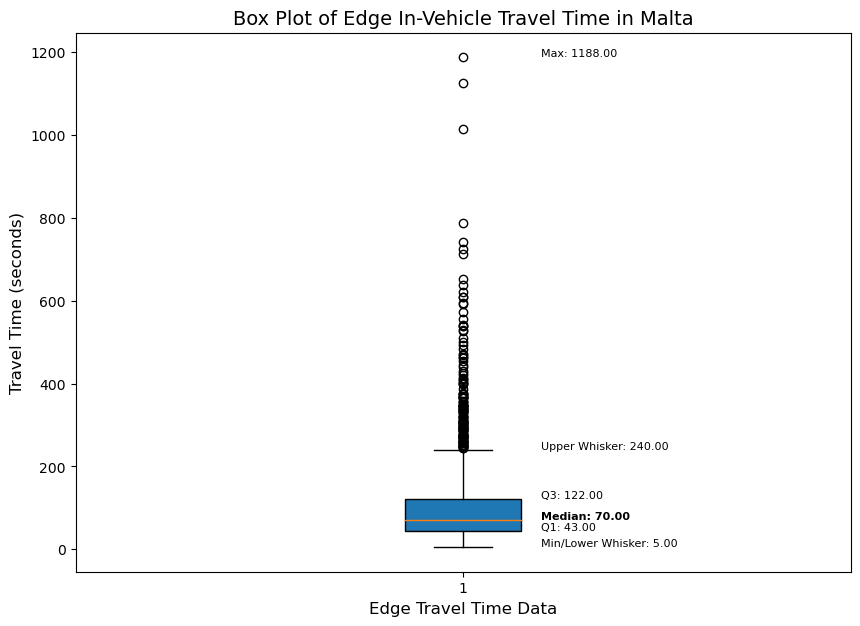

In [71]:
# Step 5.3 - Obtaining Information related to Malta (Time)

# Find edge with maximum travel time 
Malta_DistinctEdges_IncTravelTimes_Min[Malta_DistinctEdges_IncTravelTimes_Min['Travel_Time'] == Malta_DistinctEdges_IncTravelTimes_Min['Travel_Time'].max()]
# Find average travelling time throughout all edges
Average_TravelTime = Malta_DistinctEdges_IncTravelTimes_Min['Travel_Time'].mean()
# Find median travelling time throughout all edges
Median_TravelTime = Malta_DistinctEdges_IncTravelTimes_Min['Travel_Time'].median()
# Obtain box plot of Travel Time

# Removing Errors by Changing Data Type to numeric
Travel_TimeData = pd.to_numeric(Malta_DistinctEdges_IncTravelTimes_Min['Travel_Time'], errors='coerce').dropna()


# Obtaining further statistics
minimum = np.min(Travel_TimeData)
Q1 = np.percentile(Travel_TimeData, 25)
median = np.median(Travel_TimeData)
Q3 = np.percentile(Travel_TimeData, 75)
maximum = np.max(Travel_TimeData)
# Compute interquartile range (IQR)
IQR = Q3 - Q1
# Compute whiskers (last values before outliers)
lower_whisker = np.min(Travel_TimeData[Travel_TimeData >= (Q1 - 1.5 * IQR)].astype(float))
upper_whisker = np.max(Travel_TimeData[Travel_TimeData <= (Q3 + 1.5 * IQR)].astype(float))

# Defining figure size
Figure = plt.figure(figsize =(10, 7))
plt.boxplot(Travel_TimeData, vert = True, patch_artist = True)

# Add title, y-axis and x-axis
plt.xlabel("Edge Travel Time Data", fontsize = 12)
plt.ylabel("Travel Time (seconds)", fontsize = 12)
plt.title("Box Plot of Edge In-Vehicle Travel Time in Malta", fontsize = 14)


plt.annotate(f"Min/Lower Whisker: {minimum:.2f}", 
             xy=(1, minimum), 
             xytext=(1.1, minimum + 2),
             fontsize=8)

plt.annotate(f"Q1: {Q1:.2f}", 
             xy=(1, Q1), 
             xytext=(1.1, Q1 + 2),
             fontsize=8)

plt.annotate(f"Median: {median:.2f}", 
             xy=(1, median), 
             xytext=(1.1, median + 2),
             fontsize=8, fontweight='bold')

plt.annotate(f"Q3: {Q3:.2f}", 
             xy=(1, Q3), 
             xytext=(1.1, Q3 + 2),
             fontsize=8)

plt.annotate(f"Max: {maximum:.2f}", 
             xy=(1, maximum), 
             xytext=(1.1, maximum + 2),
             fontsize=8)

plt.annotate(f"Upper Whisker: {upper_whisker:.2f}", 
             xy=(1, upper_whisker), 
             xytext=(1.1, upper_whisker + 2), 
             fontsize=8)

# Show the plot
plt.show()

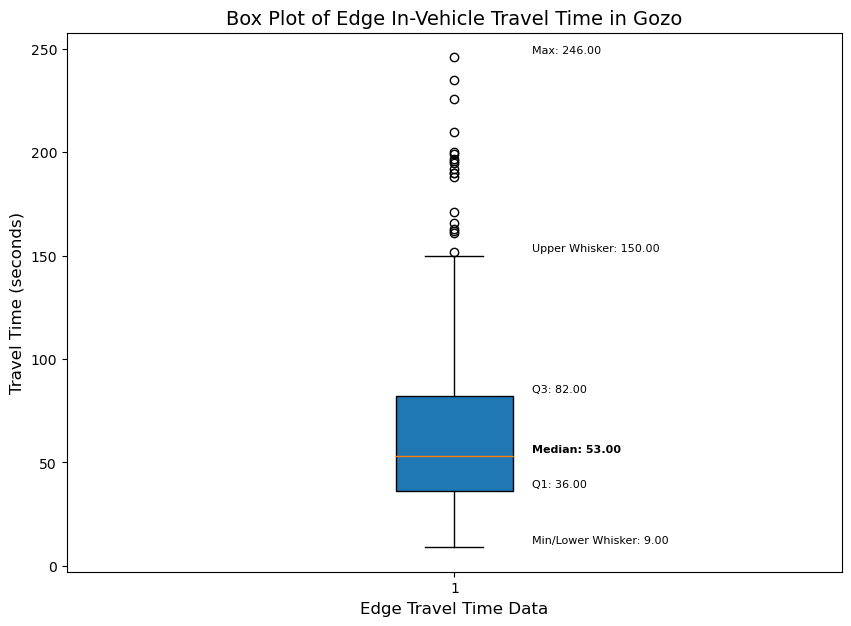

In [77]:
# Step 5.4 - Obtaining Information related to Gozo (Time)

# Find edge with maximum travel time 
Gozo_DistinctEdges_IncTravelTimes_Min[Gozo_DistinctEdges_IncTravelTimes_Min['Travel_Time'] == Gozo_DistinctEdges_IncTravelTimes_Min['Travel_Time'].max()]
# Find average travelling time throughout all edges
Average_TravelTime = Gozo_DistinctEdges_IncTravelTimes_Min['Travel_Time'].mean()
# Find median travelling time throughout all edges
Median_TravelTime = Gozo_DistinctEdges_IncTravelTimes_Min['Travel_Time'].median()

# Obtain box plot of Travel Time
# Example data (replace this with your actual DataFrame column)
Travel_TimeData = pd.to_numeric(Gozo_DistinctEdges_IncTravelTimes_Min['Travel_Time'], errors='coerce').dropna()

# Obtaining further statistics
minimum = np.min(Travel_TimeData)
Q1 = np.percentile(Travel_TimeData, 25)
median = np.median(Travel_TimeData)
Q3 = np.percentile(Travel_TimeData, 75)
maximum = np.max(Travel_TimeData)
# Compute interquartile range (IQR)
IQR = Q3 - Q1
# Compute whiskers (last values before outliers)
lower_whisker = np.min(Travel_TimeData[Travel_TimeData >= (Q1 - 1.5 * IQR)].astype(float))
upper_whisker = np.max(Travel_TimeData[Travel_TimeData <= (Q3 + 1.5 * IQR)].astype(float))

# Defining figure size
Figure = plt.figure(figsize =(10, 7))
plt.boxplot(Travel_TimeData, vert = True, patch_artist = True)

# Add title, y-axis and x-axis
plt.xlabel("Edge Travel Time Data", fontsize = 12)
plt.ylabel("Travel Time (seconds)", fontsize = 12)
plt.title("Box Plot of Edge In-Vehicle Travel Time in Gozo", fontsize = 14)

#Annotate Values to Box Plot
plt.annotate(f"Min/Lower Whisker: {minimum:.2f}", 
             xy=(1, minimum), 
             xytext=(1.1, minimum + 2),
             fontsize=8)

plt.annotate(f"Q1: {Q1:.2f}", 
             xy=(1, Q1), 
             xytext=(1.1, Q1 + 2),
             fontsize=8)

plt.annotate(f"Median: {median:.2f}", 
             xy=(1, median), 
             xytext=(1.1, median + 2),
             fontsize=8, fontweight='bold')

plt.annotate(f"Q3: {Q3:.2f}", 
             xy=(1, Q3), 
             xytext=(1.1, Q3 + 2),
             fontsize=8)

plt.annotate(f"Max: {maximum:.2f}", 
             xy=(1, maximum), 
             xytext=(1.1, maximum + 2),
             fontsize=8)

plt.annotate(f"Upper Whisker: {upper_whisker:.2f}", 
             xy=(1, upper_whisker), 
             xytext=(1.1, upper_whisker + 2), 
             fontsize=8)



plt.show()

In [61]:
# Step 5.5 - Data Cleaning (Take shortest path if available ex. Stop 3 to Stop 819 is 56 seconds long on the otherhand Stop 819 to Stop 3
# is 1019 seconds long (The former is correct))

# Standardize route names to be order-independent
Malta_DistinctEdges_IncTravelTimes['Standardized_Route'] = Malta_DistinctEdges_IncTravelTimes['Bus_Stop_Next_Bus_Stop'].apply(lambda x: '_to_'.join(sorted(x.split('_to_'))))
# Keep the row with the minimum travel time for each standardized route
Malta_DistinctEdges_IncTravelTimes_MinLength = Malta_DistinctEdges_IncTravelTimes.loc[Malta_DistinctEdges_IncTravelTimes.groupby('Standardized_Route')['Length_In_Metres'].idxmin()]
# Drop the helper column if not needed
Malta_DistinctEdges_IncTravelTimes_MinLength = Malta_DistinctEdges_IncTravelTimes_MinLength.drop(columns=['Standardized_Route'])


# Standardize route names to be order-independent
Gozo_DistinctEdges_IncTravelTimes['Standardized_Route'] = Gozo_DistinctEdges_IncTravelTimes['Bus_Stop_Next_Bus_Stop'].apply(lambda x: '_to_'.join(sorted(x.split('_to_'))))
# Keep the row with the minimum travel time for each standardized route
Gozo_DistinctEdges_IncTravelTimes_MinLength = Gozo_DistinctEdges_IncTravelTimes.loc[Gozo_DistinctEdges_IncTravelTimes.groupby('Standardized_Route')['Length_In_Metres'].idxmin()]
# Drop the helper column if not needed
Gozo_DistinctEdges_IncTravelTimes_MinLength = Gozo_DistinctEdges_IncTravelTimes_MinLength.drop(columns=['Standardized_Route'])

# Saving DataFrames
Malta_DistinctEdges_IncTravelTimes_MinLength.to_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Distinct_Edges_MALTA_IncTravelTimes_WrongPathFixLength.csv")
Gozo_DistinctEdges_IncTravelTimes_MinLength.to_csv("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Distinct_Edges_GOZO_IncTravelTimes_WrongPathFixLength.csv")

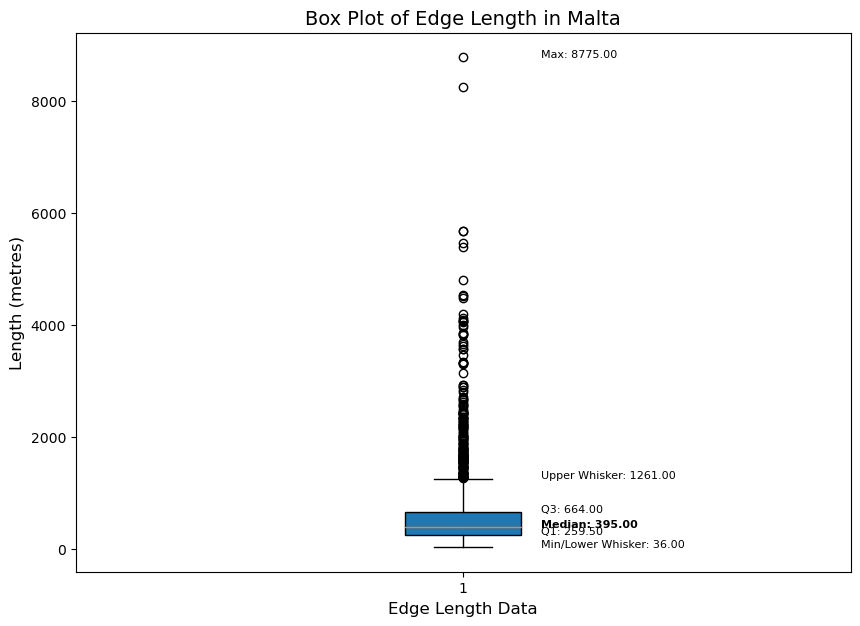

In [73]:
# Step 5.6 - Obtaining Information related to Malta (Length)

# Find edge with maximum travel time 
Malta_DistinctEdges_IncTravelTimes_MinLength[Malta_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'] == Malta_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'].max()]
# Find average travelling time throughout all edges
Average_Length = Malta_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'].mean()
# Find median travelling time throughout all edges
Median_Length = Malta_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'].median()
# Obtain box plot of Travel Time

# Removing Errors by Changing Data Type to numeric
Length_Data = pd.to_numeric(Malta_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'], errors='coerce').dropna()


# Obtaining further statistics
minimum = np.min(Length_Data)
Q1 = np.percentile(Length_Data, 25)
median = np.median(Length_Data)
Q3 = np.percentile(Length_Data, 75)
maximum = np.max(Length_Data)
# Compute interquartile range (IQR)
IQR = Q3 - Q1
# Compute whiskers (last values before outliers)
lower_whisker = np.min(Length_Data[Length_Data >= (Q1 - 1.5 * IQR)].astype(float))
upper_whisker = np.max(Length_Data[Length_Data <= (Q3 + 1.5 * IQR)].astype(float))

# Defining figure size
Figure = plt.figure(figsize =(10, 7))
plt.boxplot(Length_Data, vert = True, patch_artist = True)

# Add title, y-axis and x-axis
plt.xlabel("Edge Length Data", fontsize = 12)
plt.ylabel("Length (metres)", fontsize = 12)
plt.title("Box Plot of Edge Length in Malta", fontsize = 14)


plt.annotate(f"Min/Lower Whisker: {minimum:.2f}", 
             xy=(1, minimum), 
             xytext=(1.1, minimum + 2),
             fontsize=8)

plt.annotate(f"Q1: {Q1:.2f}", 
             xy=(1, Q1), 
             xytext=(1.1, Q1 + 2),
             fontsize=8)

plt.annotate(f"Median: {median:.2f}", 
             xy=(1, median), 
             xytext=(1.1, median + 2),
             fontsize=8, fontweight='bold')

plt.annotate(f"Q3: {Q3:.2f}", 
             xy=(1, Q3), 
             xytext=(1.1, Q3 + 2),
             fontsize=8)

plt.annotate(f"Max: {maximum:.2f}", 
             xy=(1, maximum), 
             xytext=(1.1, maximum + 2),
             fontsize=8)

plt.annotate(f"Upper Whisker: {upper_whisker:.2f}", 
             xy=(1, upper_whisker), 
             xytext=(1.1, upper_whisker + 2), 
             fontsize=8)

# Show the plot
plt.show()

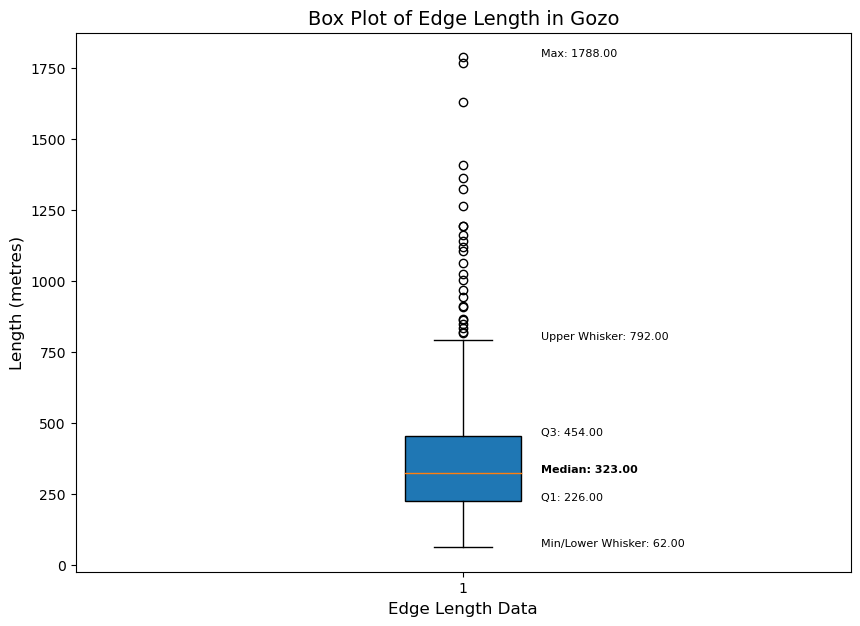

In [74]:
# Step 5.6 - Obtaining Information related to Gozo (Length)

# Find edge with maximum travel time 
Gozo_DistinctEdges_IncTravelTimes_MinLength[Gozo_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'] == Gozo_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'].max()]
# Find average travelling time throughout all edges
Average_Length = Gozo_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'].mean()
# Find median travelling time throughout all edges
Median_Length = Gozo_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'].median()
# Obtain box plot of Travel Time

# Removing Errors by Changing Data Type to numeric
Length_Data = pd.to_numeric(Gozo_DistinctEdges_IncTravelTimes_MinLength['Length_In_Metres'], errors='coerce').dropna()


# Obtaining further statistics
minimum = np.min(Length_Data)
Q1 = np.percentile(Length_Data, 25)
median = np.median(Length_Data)
Q3 = np.percentile(Length_Data, 75)
maximum = np.max(Length_Data)
# Compute interquartile range (IQR)
IQR = Q3 - Q1
# Compute whiskers (last values before outliers)
lower_whisker = np.min(Length_Data[Length_Data >= (Q1 - 1.5 * IQR)].astype(float))
upper_whisker = np.max(Length_Data[Length_Data <= (Q3 + 1.5 * IQR)].astype(float))

# Defining figure size
Figure = plt.figure(figsize =(10, 7))
plt.boxplot(Length_Data, vert = True, patch_artist = True)

# Add title, y-axis and x-axis
plt.xlabel("Edge Length Data", fontsize = 12)
plt.ylabel("Length (metres)", fontsize = 12)
plt.title("Box Plot of Edge Length in Gozo", fontsize = 14)


plt.annotate(f"Min/Lower Whisker: {minimum:.2f}", 
             xy=(1, minimum), 
             xytext=(1.1, minimum + 2),
             fontsize=8)

plt.annotate(f"Q1: {Q1:.2f}", 
             xy=(1, Q1), 
             xytext=(1.1, Q1 + 2),
             fontsize=8)

plt.annotate(f"Median: {median:.2f}", 
             xy=(1, median), 
             xytext=(1.1, median + 2),
             fontsize=8, fontweight='bold')

plt.annotate(f"Q3: {Q3:.2f}", 
             xy=(1, Q3), 
             xytext=(1.1, Q3 + 2),
             fontsize=8)

plt.annotate(f"Max: {maximum:.2f}", 
             xy=(1, maximum), 
             xytext=(1.1, maximum + 2),
             fontsize=8)

plt.annotate(f"Upper Whisker: {upper_whisker:.2f}", 
             xy=(1, upper_whisker), 
             xytext=(1.1, upper_whisker + 2), 
             fontsize=8)

# Show the plot
plt.show()

### Step 6 - Analysing Most Popular Stops

In [111]:
Malta_City_POP = pd.read_excel("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Malta_POP.xlsx")
GOZO_City_POP = pd.read_excel("C://Users//Owner//ICT5012 - Disseration//Chapter 3 - Data Visualisation//Files used for Data Visualisation//Gozo_POP.xlsx")

In [112]:
Malta_City_POP

,City,Population
0,Il-Mosta,21539
1,Il-Bidnija,270
2,Il-Floriana,2040
3,Birkirkara,17145
4,Is-Swatar,5744
...,...,...
78,Ghajn Tuffieha,1348
79,Il-Gudja,3033
80,Il-Birgu,2265
81,L-Isla,2332


In [113]:
# Obtain Number of Stops in each city
Unique_Stops_DF = Monday_Routes_Malta.drop_duplicates(subset=["Bus_Stop_ID"], keep="first")
city_counts_df = Unique_Stops_DF["City Name"].value_counts().reset_index()
city_counts_df.columns = ["City", "Frequency"]

In [114]:
# Merge ' Malta_City_POP' and 'city_counts_df'
city_counts_df

,City,Frequency
0,Il-Mosta,55
1,Il-Belt Valletta,49
2,"Ir-Rabat, Malta",46
3,Marsaskala,44
4,Birkirkara,36
...,...,...
77,Tal-Pietà,2
78,Ir-Rinella,2
79,San Vincenz,2
80,Bulebel,2


In [115]:
City_Info = pd.merge(Malta_City_POP, city_counts_df, on="City", how="inner")


In [116]:
City_Info
# Add Pieta Row
City_Info.loc[len(City_Info)] = ['Tal-Pietà', 6132, 2]

In [117]:
City_Info['Population per Stop'] = City_Info['Population']/City_Info['Frequency']
City_Info['Population per Stop'] = City_Info['Population per Stop'].round(0)

In [118]:
City_Info

,City,Population,Frequency,Population per Stop
0,Il-Mosta,21539,55,392.0
1,Il-Bidnija,270,2,135.0
2,Il-Floriana,2040,21,97.0
3,Birkirkara,17145,36,476.0
4,Is-Swatar,5744,10,574.0
...,...,...,...,...
77,Il-Gudja,3033,12,253.0
78,Il-Birgu,2265,7,324.0
79,L-Isla,2332,3,777.0
80,L-Iklin,3296,4,824.0


In [119]:
UniqueIndRidingBusesPerYear = 309300

In [120]:
TotPop = City_Info['Population'].sum()

In [121]:
Prop_Ind_Bus = UniqueIndRidingBusesPerYear/TotPop

In [122]:
Prop_UseAtPeak = 0.2

In [123]:
City_Info['Total Trips from each zone'] = City_Info['Population per Stop'] * Prop_Ind_Bus * Prop_UseAtPeak
City_Info['Total Trips from each zone'] = City_Info['Total Trips from each zone'].round(0)

In [124]:
City_Info

,City,Population,Frequency,Population per Stop,Total Trips from each zone
0,Il-Mosta,21539,55,392.0,51.0
1,Il-Bidnija,270,2,135.0,18.0
2,Il-Floriana,2040,21,97.0,13.0
3,Birkirkara,17145,36,476.0,62.0
4,Is-Swatar,5744,10,574.0,75.0
...,...,...,...,...,...
77,Il-Gudja,3033,12,253.0,33.0
78,Il-Birgu,2265,7,324.0,42.0
79,L-Isla,2332,3,777.0,102.0
80,L-Iklin,3296,4,824.0,108.0


In [125]:
TotStops = City_Info['Frequency'].sum()

In [144]:
(2/1135 * 309300 * 0.2)/2

54.50220264317181

In [156]:
City_Info['Total Trips to each zone'] = (City_Info['Frequency']/TotStops) * City_Info['Population per Stop']
City_Info['Total Trips to each zone'] = City_Info['Total Trips to each zone'].round(0)

In [152]:
City_Info['Total Trips to each zone'] = City_Info['Total Trips to each zone']/City_Info['Frequency']
City_Info['Total Trips to each zone'] = City_Info['Total Trips to each zone'].round(0)

In [157]:
City_Info

,City,Population,Frequency,Population per Stop,Total Trips from each zone,Total Trips to each zone
0,Il-Mosta,21539,55,392.0,51.0,19.0
1,Il-Bidnija,270,2,135.0,18.0,0.0
2,Il-Floriana,2040,21,97.0,13.0,2.0
3,Birkirkara,17145,36,476.0,62.0,15.0
4,Is-Swatar,5744,10,574.0,75.0,5.0
...,...,...,...,...,...,...
77,Il-Gudja,3033,12,253.0,33.0,3.0
78,Il-Birgu,2265,7,324.0,42.0,2.0
79,L-Isla,2332,3,777.0,102.0,2.0
80,L-Iklin,3296,4,824.0,108.0,3.0


In [138]:
Calc

61876.0

In [143]:
TotStops

1135